In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

# Approche hybride avec LightFM

## Données

### Chargement du dataframe global

In [2]:
import pandas as pd

df_clicks = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [3]:
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,-0.269690,0.873445,0.194144,0.056367,-0.431036,-0.020383,-0.376942,0.814494,0.709722,-1.030146
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,0.144034,-2.457183,-1.500929,-1.807169,-0.208940,-0.671638,-0.407914,2.561696,-1.379031,-1.877568
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,-1.163678,-0.230112,-2.132536,-0.729996,0.581913,-0.559910,-0.354824,-0.914158,-0.064399,-0.354175


## Matrice utilisateur-item

| Situation | Stratégie sur la matrice user-item | Raison |
|----------|-------------------------------------|--------|
| **Collaborative pur** (pas de features) | 🔥 Maximiser l'intensité : `alpha` élevé, `weighting='log'`, **pas de normalisation** | Cela amplifie les différences de préférence et donne du signal fort à LightFM |
| **Hybride (avec user/item features)** | ⚖️ Normalisation cohérente des valeurs dans `[0, 1]` sur **toutes les matrices** (y compris interactions) | Cela évite que les features soient écrasées ou négligées par un déséquilibre d’échelle | 

<br>
C'est le principe de <b>l'équilibrage des signaux dans les systèmes hybrides de recommandation</b>. Si on normalise seulement les features mais la matrice user-item reste avec des valeurs hautes les features seront ignées par le le modèle. Si on normalise tout il faut éviter d'écraser la variance <br>

🛠️ Bonnes pratiques à appliquer<br>
| Élément | Bonne échelle |
|--------|----------------|
| `user_features` | `[0, 1]` (via MinMax ou OneHot) |
| `item_features` | `[0, 1]` (MinMax + embeddings déjà compressés) |
| `interaction_matrix` | `[0, 1]` uniquement si features aussi présentes (sinon garder amplitudes fortes) |

In [4]:
from scipy.sparse import coo_matrix
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def build_user_item_matrix_for_lightfm(
    df_clicks,
    weighting="log",
    alpha=40.0,
    normalize=False,
    binarize=False,
    min_user_interactions=0,
    max_weight_clip=None,
    return_stats=False
):
    """
    Construit une matrice CSR (utilisateurs × articles) pour LightFM avec pondération, normalisation,
    binarisation et filtrage optionnels.

    Paramètres :
    - df_clicks : DataFrame avec 'user_id' et 'click_article_id'
    - weighting : 'log' ou 'linear' — ignoré si binarize=True
    - alpha : facteur de pondération log
    - normalize : False, 'minmax', 'standard', 'log', 'user_minmax', 'user_standard' ou fonction
    - binarize : bool, met tous les poids à 1
    - min_user_interactions : filtre les utilisateurs ayant < interactions
    - max_weight_clip : valeur max à appliquer aux poids (None = pas de clipping)
    - return_stats : bool, affiche les stats de la matrice finale

    Retourne :
    - user_item_matrix : matrice CSR (n_users × n_items)
    - user_mapping : dict {user_id → user_idx}
    - item_mapping : dict {click_article_id → item_idx}
    """

    # 1. Agrégation des clics
    df_user_item = (
        df_clicks.groupby(['user_id', 'click_article_id'])
        .size()
        .reset_index(name='click_strength')
    )

    # 2. Filtrage des utilisateurs
    if min_user_interactions > 0:
        counts = df_user_item.groupby('user_id')['click_article_id'].nunique()
        valid_users = counts[counts >= min_user_interactions].index
        df_user_item = df_user_item[df_user_item['user_id'].isin(valid_users)]
        print(f"🔍 Filtrage : {len(valid_users)} utilisateurs conservés (≥ {min_user_interactions} interactions)")

    # 3. Mappings
    print("🔄 Construction des dictionnaires d’indexation...")
    user_ids = df_user_item['user_id'].unique()
    item_ids = df_user_item['click_article_id'].unique()

    user_mapping = {uid: idx for idx, uid in enumerate(tqdm(user_ids, desc="🔢 Mapping users"))}
    item_mapping = {iid: idx for idx, iid in enumerate(tqdm(item_ids, desc="🧾 Mapping articles"))}

    df_user_item['user_idx'] = df_user_item['user_id'].map(user_mapping)
    df_user_item['item_idx'] = df_user_item['click_article_id'].map(item_mapping)

    # 4. Pondération ou binarisation
    if binarize:
        print("⚪️ Mode binaire activé (poids = 1.0)")
        df_user_item['weight'] = 1.0
    else:
        if weighting == "log":
            df_user_item['weight'] = 1.0 + alpha * np.log1p(df_user_item['click_strength'])
            print(f"🧮 Pondération logarithmique avec alpha={alpha}")
        elif weighting == "linear":
            df_user_item['weight'] = df_user_item['click_strength'].astype(float)
            print("🧮 Pondération linéaire")
        else:
            raise ValueError("Le paramètre 'weighting' doit être 'log' ou 'linear'.")

    # 5. Clipping éventuel des poids
    if max_weight_clip is not None:
        df_user_item['weight'] = np.minimum(df_user_item['weight'], max_weight_clip)
        print(f"✂️ Clipping des poids à max={max_weight_clip}")

    # 6. Normalisation éventuelle
    if normalize:
        print(f"📏 Normalisation des poids : {normalize}")
        if normalize == 'minmax':
            scaler = MinMaxScaler()
            df_user_item['weight'] = scaler.fit_transform(df_user_item[['weight']])
        elif normalize == 'standard':
            scaler = StandardScaler()
            df_user_item['weight'] = scaler.fit_transform(df_user_item[['weight']])
        elif normalize == 'log':
            df_user_item['weight'] = np.log1p(df_user_item['weight'])
        elif normalize == 'user_minmax':
            df_user_item['weight'] = df_user_item.groupby('user_idx')['weight'].transform(
                lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
            )
        elif normalize == 'user_standard':
            df_user_item['weight'] = df_user_item.groupby('user_idx')['weight'].transform(
                lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
            )
        elif callable(normalize):
            df_user_item['weight'] = normalize(df_user_item['weight'].values)
        else:
            raise ValueError("Paramètre 'normalize' invalide.")

    # 7. Construction de la matrice sparse
    print("📐 Construction de la matrice sparse (CSR)...")
    user_item_matrix = coo_matrix(
        (df_user_item['weight'],
         (df_user_item['user_idx'], df_user_item['item_idx']))
    ).tocsr()

    print(f"✅ Matrice prête : {user_item_matrix.shape} (utilisateurs × articles)")

    # 8. Statistiques
    if return_stats:
        n_users, n_items = user_item_matrix.shape
        nnz = user_item_matrix.nnz
        density = 100 * nnz / (n_users * n_items)
        print(f"\n📊 Statistiques de la matrice :")
        print(f" - Dimensions : {n_users:,} utilisateurs × {n_items:,} articles")
        print(f" - Interactions non nulles : {nnz:,}")
        print(f" - Densité : {density:.5f} %")
        print(f" - Moyenne interactions/utilisateur : {nnz / n_users:.2f}")
        print(f" - Moyenne interactions/article : {nnz / n_items:.2f}")
        print(f" - Max poids d’interaction : {user_item_matrix.max():.2f}")

    return user_item_matrix, user_mapping, item_mapping


In [5]:
# Création de la matrice et des mappages d'index
# # Pas de normalisation (collaborative pur)
# build_user_item_matrix_for_lightfm(df_clicks, normalize=False)
# # Hybride avec normalisation MinMax
# build_user_item_matrix_for_lightfm(df_clicks, normalize='minmax')
# # Hybride avec log compression
# build_user_item_matrix_for_lightfm(df_clicks, normalize='log')
# # Mode binaire (vraiment implicite binaire, pour test baseline)
# mat_bin, _, _ = build_user_item_matrix_for_lightfm(
#     df_clicks, binarize=True
# )

user_item_matrix, user_mapping, item_mapping = build_user_item_matrix_for_lightfm(
    df_clicks,
    weighting='log',
    alpha=40.0,
    normalize=False,
    binarize=False,
    min_user_interactions=3,
    max_weight_clip=100,
    return_stats=True
)



🔍 Filtrage : 221379 utilisateurs conservés (≥ 3 interactions)
🔄 Construction des dictionnaires d’indexation...


🧾 Mapping articles: 100%|██████████| 41367/41367 [00:00<00:00, 4968095.68it/s]


🧮 Pondération logarithmique avec alpha=40.0
✂️ Clipping des poids à max=100
📐 Construction de la matrice sparse (CSR)...
✅ Matrice prête : (221379, 41367) (utilisateurs × articles)

📊 Statistiques de la matrice :
 - Dimensions : 221,379 utilisateurs × 41,367 articles
 - Interactions non nulles : 2,747,674
 - Densité : 0.03000 %
 - Moyenne interactions/utilisateur : 12.41
 - Moyenne interactions/article : 66.42
 - Max poids d’interaction : 100.00


<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>Note :</strong> Contrairement à Implicit on ne filtre pas les utilisateurs ayant moins de 3 interactions afin de ne pas occulter la situation correspond à beaucoup de cas: utilisateur peu actif. Les métriques seront sans doute moins bonnes qu'avec un filtrage
</div>

### Visualisation rapide de la matrice user_item_matrix

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_user_item_heatmap(matrix, n_users=100, n_items=100):
    sub_matrix = matrix[:n_users, :n_items].toarray()

    plt.figure(figsize=(10, 8))
    plt.imshow(sub_matrix, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar(label="Poids d'interaction")
    plt.xlabel("Articles")
    plt.ylabel("Utilisateurs")
    plt.title(f"Matrice user-item ({n_users}×{n_items})")
    plt.tight_layout()
    plt.show()


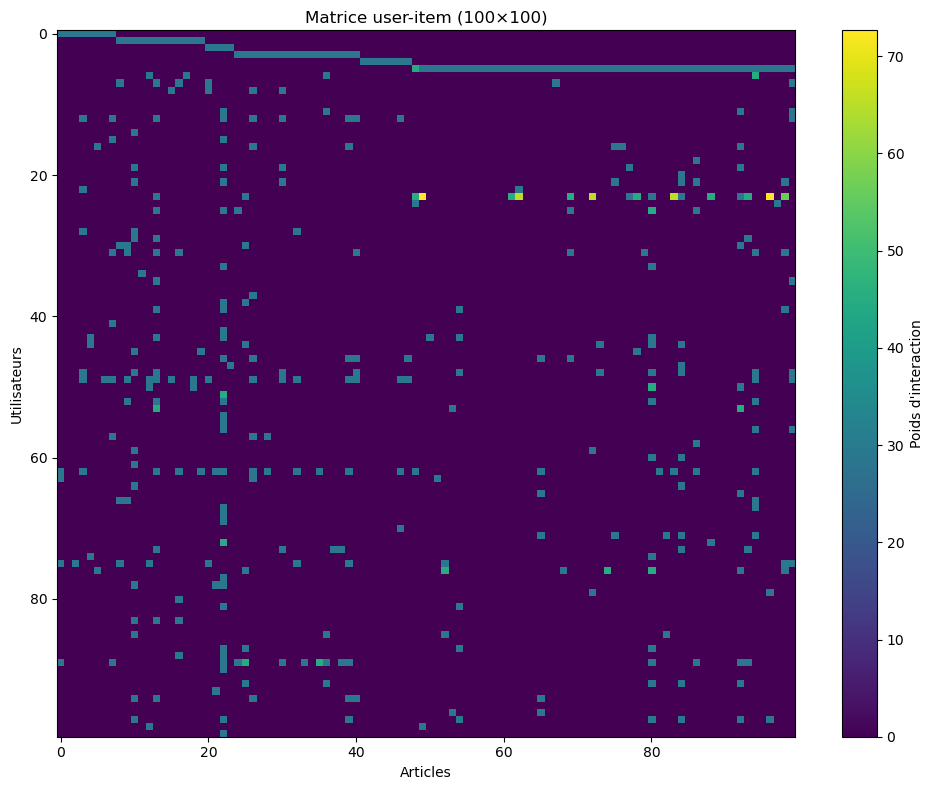

In [7]:
plot_user_item_heatmap(user_item_matrix, n_users=100, n_items=100)

In [8]:
import seaborn as sns
import pandas as pd

def plot_interaction_distribution(matrix):
    interactions_per_user = np.array((matrix > 0).sum(axis=1)).flatten()
    
    sns.histplot(interactions_per_user, bins=100, log_scale=(False, True))
    plt.xlabel("Nombre d'interactions par utilisateur")
    plt.ylabel("Nombre d'utilisateurs")
    plt.title("Distribution des interactions utilisateur")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


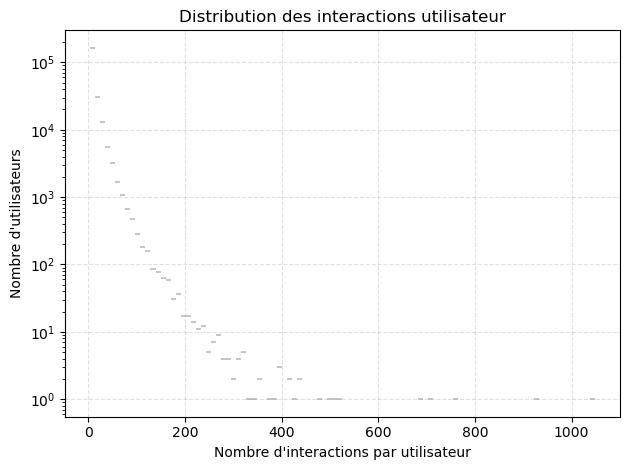

In [9]:
plot_interaction_distribution(user_item_matrix)

## Split LOO

In [7]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix

def leave_one_out_split(interactions):
    """
    Réalise un split Leave-One-Out sur une matrice utilisateurs × articles.
    
    Paramètres :
    - interactions : csr_matrix (n_users x n_items)

    Retourne :
    - train : csr_matrix (interactions moins 1 par utilisateur)
    - test : csr_matrix (1 interaction par utilisateur)
    """
    assert isinstance(interactions, csr_matrix), "La matrice d'entrée doit être au format CSR."

    print("🔄 Split Leave-One-Out en cours...")

    interactions = interactions.tolil()  # Accès rapide ligne par ligne
    n_users, n_items = interactions.shape

    train = lil_matrix(interactions.shape, dtype=np.float32)
    test = lil_matrix(interactions.shape, dtype=np.float32)

    rng = np.random.default_rng(seed=42)  # Pour reproductibilité

    for user_id in range(n_users):
        user_interactions = interactions.rows[user_id]
        user_data = interactions.data[user_id]

        if len(user_interactions) >= 2:
            idx = rng.integers(0, len(user_interactions))

            test_item = user_interactions[idx]
            test_value = user_data[idx]

            # Ajouter au test
            test[user_id, test_item] = test_value

            # Ajouter le reste au train
            for i, item in enumerate(user_interactions):
                if i != idx:
                    train[user_id, item] = user_data[i]
        else:
            for i, item in enumerate(user_interactions):
                train[user_id, item] = user_data[i]

    print(f"✅ Split terminé :\n - Train shape : {train.shape}\n - Test shape : {test.shape}")
    return train.tocsr(), test.tocsr()


In [8]:
# Jeux de train et test
train_matrix, test_matrix = leave_one_out_split(user_item_matrix)

🔄 Split Leave-One-Out en cours...
✅ Split terminé :
 - Train shape : (221379, 41367)
 - Test shape : (221379, 41367)


<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>✨ Fonctionnement :</strong> tolil() ➔ convertit temporairement en LIL (list of lists). C'est une structure de matrice creuse qui stocke pour chaque ligne une liste de colonnes non-nulles, une autre list associée qui contient les valeurs de ces colonnes. Donc par ligne on garde: un tableau des indices de colonnes non nulles, un tableau des valeurs correspondantes. Format adapté pour construire, CSR est meilleur pour les calculs (matmul) et la mise en oeuvre du modèle
</div>

## Métriques

### Métriques de recommantion

👉 NDCG@k (Normalized Discounted Cumulative Gain) doit être calculé à la main car LightFM ne le donne pas directement.

In [9]:
from tqdm.notebook import tqdm
import numpy as np
from joblib import Parallel, delayed

def ndcg_at_k(model, test_interactions, train_interactions=None, 
              user_features=None, item_features=None, 
              k=5, num_threads=8):
    """
    Calcule le NDCG@k utilisateur par utilisateur (vectorisé + parallélisé).
    """
    n_users, n_items = test_interactions.shape
    test_csr = test_interactions.tocsr()
    train_csr = train_interactions.tocsr() if train_interactions is not None else None

    def compute_ndcg(user_id):
        true_items = test_csr[user_id].indices
        if len(true_items) == 0:
            return None

        scores = np.array(model.predict(
            user_id,
            np.arange(n_items),
            user_features=user_features,
            item_features=item_features,
            num_threads=1
        )).copy() # rend l'array modifiable

        # Masquer les items vus pendant le training
        if train_csr is not None:
            train_items = train_csr[user_id].indices
            scores[train_items] = -np.inf

        top_k_items = np.argpartition(-scores, k)[:k]
        top_k_items = top_k_items[np.argsort(-scores[top_k_items])]  # tri final

        relevances = np.isin(top_k_items, true_items).astype(int)
        dcg = np.sum(relevances / np.log2(np.arange(2, k + 2)))
        idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k) + 2)))

        return dcg / idcg if idcg > 0 else 0.0

    results = Parallel(n_jobs=num_threads, backend="threading")(
        delayed(compute_ndcg)(user_id)
        for user_id in tqdm(range(n_users), total=n_users, desc="Calcul NDCG@k (parallèle)")
    )

    results = [r for r in results if r is not None]  # supprimer les utilisateurs sans clics
    return np.mean(results) if results else 0.0


### Erreurs RMSE et MAE

📚 Note: LightFM est principalement conçu pour optimiser du ranking (ordre des items) et travailler sur des interactions implicites (clic, vue, achat = 1 ou pas = 0).<br>
RMSE (Root Mean Squared Error) et MAE (Mean Absolute Error) sont normalement utilisés sur :<br>
- des valeurs continues (ex : prédiction d'une note sur 5).
- des modèles de prédiction de score explicite (comme SVD dans Surprise).
  
<br>
👉 Or LightFM peut quand même prédire un score implicite (predict(user, item)) continu. Ce sont des scores relatifs, pas des probabilités calibrées. <br>
👉 Donc on peut comparer ces scores aux clics réels (1 s'il a cliqué, 0 sinon). On a bien une proximité entre le score prédit et le clic réel.<br>
<b>Métriques données pour information, elles ne constituent pas un critère pour LightFM </b>

In [23]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from joblib import Parallel, delayed

def compute_rmse_mae_normalized(model, test_interactions, train_interactions=None,
                                user_features=None, item_features=None,
                                num_threads=8):
    """
    Calcule RMSE et MAE normalisés (Min-Max par utilisateur) pour LightFM.
    """
    n_users, n_items = test_interactions.shape
    test_csr = test_interactions.tocsr()
    train_csr = train_interactions.tocsr() if train_interactions is not None else None

    def compute_user_predictions(user_id):
        true_items = test_csr[user_id].indices
        if len(true_items) == 0:
            return [], []

        scores = np.array(model.predict(
            user_id,
            np.arange(n_items),
            user_features=user_features,
            item_features=item_features,
            num_threads=1
        )).copy()

        if train_csr is not None:
            train_items = train_csr[user_id].indices
            scores[train_items] = -np.inf

        # Normalisation Min-Max par utilisateur
        finite_scores = scores[np.isfinite(scores)]
        if finite_scores.size == 0 or np.all(finite_scores == finite_scores[0]):
            return [], []

        min_s, max_s = finite_scores.min(), finite_scores.max()
        scores = (scores - min_s) / (max_s - min_s + 1e-10)  # évite div/0

        y_t = [1] * len(true_items)
        y_p = [scores[item] for item in true_items]

        return y_t, y_p

    results = Parallel(n_jobs=num_threads, backend="threading")(
        delayed(compute_user_predictions)(user_id)
        for user_id in tqdm(range(n_users), total=n_users, desc="Calcul RMSE/MAE normalisés")
    )

    y_true, y_pred = [], []
    for y_t, y_p in results:
        y_true.extend(y_t)
        y_pred.extend(y_p)

    if not y_true:
        raise ValueError("Aucune interaction à évaluer.")

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae

## Entrainement (baseline: matrice user-item)
🧩 Étape 1 — LightFM fonctionne avec une simple interaction matrix.Chaque item et chaque user est représenté par un vecteur appris automatiquement.<br>
➡️ Résultat : modèle purement collaboratif.

In [11]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from itertools import product
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import os

def grid_search_lightfm(train_matrix, test_matrix,
                        user_features=None, item_features=None,
                        k=5, num_threads=8, max_epochs=30,
                        eval_metric="precision",
                        eval_every=5, patience=3,
                        param_grid=None,
                        min_metric_threshold=0.0,
                        save_results_path="./results/lightfm_gridsearch_epochs.csv"):
    """
    Grid search avec early stopping pour LightFM, avec user/item features et régularisation.
    Évite d'entraîner inutilement si la métrique est trop basse dès la première évaluation.
    Returns best_model, best_params, best_global_score
    """

    from lightfm import LightFM
    from lightfm.evaluation import precision_at_k, recall_at_k
    from itertools import product
    from tqdm.notebook import tqdm
    from joblib import Parallel, delayed
    import numpy as np
    import pandas as pd
    import os

    def ndcg_at_k(model, test_interactions, train_interactions=None, 
                  user_features=None, item_features=None, 
                  k=5, num_threads=8):
        n_users, n_items = test_interactions.shape
        test_csr = test_interactions.tocsr()
        train_csr = train_interactions.tocsr() if train_interactions is not None else None

        def compute_ndcg(user_id):
            true_items = test_csr[user_id].indices
            if len(true_items) == 0:
                return None
            scores = model.predict(
                user_id,
                np.arange(n_items),
                user_features=user_features,
                item_features=item_features,
                num_threads=1
            ).copy()
            if train_csr is not None:
                train_items = train_csr[user_id].indices
                scores[train_items] = -np.inf
            top_k_items = np.argpartition(-scores, k)[:k]
            top_k_items = top_k_items[np.argsort(-scores[top_k_items])]
            relevances = np.isin(top_k_items, true_items).astype(int)
            dcg = np.sum(relevances / np.log2(np.arange(2, k + 2)))
            idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k) + 2)))
            return dcg / idcg if idcg > 0 else 0.0

        results = Parallel(n_jobs=num_threads, backend="threading")(
            delayed(compute_ndcg)(user_id)
            for user_id in range(n_users)
        )
        results = [r for r in results if r is not None]
        return np.mean(results) if results else 0.0

    if param_grid is None:
        param_grid = {
            'loss': ['bpr'],
            'no_components': [32, 64],
            'learning_rate': [0.05, 0.1, 0.2, 0.4],
            'user_alpha': [1e-6, 1e-5, 1e-4],
            'item_alpha': [1e-6, 1e-5, 1e-4]
        }

    all_combinations = list(product(
        param_grid['loss'],
        param_grid['no_components'],
        param_grid['learning_rate'],
        param_grid['user_alpha'],
        param_grid['item_alpha']
    ))

    print(f"🔍 Recherche sur {len(all_combinations)} combinaisons...")

    best_global_score = -np.inf
    best_model = None
    best_params = None
    results_rows = []

    for loss, no_components, learning_rate, user_alpha, item_alpha in all_combinations:
        print(f"\n🚀 Entraînement modèle : loss={loss}, components={no_components}, "
              f"lr={learning_rate}, user_alpha={user_alpha}, item_alpha={item_alpha}")

        model = LightFM(
            loss=loss,
            no_components=no_components,
            learning_rate=learning_rate,
            user_alpha=user_alpha,
            item_alpha=item_alpha,
            random_state=42
        )

        best_local_score = -np.inf
        best_epoch = 0
        no_improve_count = 0

        for epoch in range(1, max_epochs + 1):
            model.fit_partial(
                train_matrix,
                user_features=user_features,
                item_features=item_features,
                epochs=1,
                num_threads=num_threads
            )

            if epoch % eval_every == 0:
                if eval_metric == "precision":
                    score = precision_at_k(
                        model, test_matrix, train_interactions=train_matrix,
                        k=k, num_threads=num_threads,
                        user_features=user_features,
                        item_features=item_features
                    ).mean()
                elif eval_metric == "recall":
                    score = recall_at_k(
                        model, test_matrix, train_interactions=train_matrix,
                        k=k, num_threads=num_threads,
                        user_features=user_features,
                        item_features=item_features
                    ).mean()
                elif eval_metric == "ndcg":
                    score = ndcg_at_k(
                        model, test_matrix, train_interactions=train_matrix,
                        user_features=user_features,
                        item_features=item_features,
                        k=k, num_threads=num_threads
                    )
                else:
                    raise ValueError("Metric invalide")

                print(f"📉 Epoch {epoch} — {eval_metric}@{k} = {score:.4f}")

                results_rows.append({
                    'loss': loss,
                    'no_components': no_components,
                    'learning_rate': learning_rate,
                    'user_alpha': user_alpha,
                    'item_alpha': item_alpha,
                    'epoch': epoch,
                    f'{eval_metric}@{k}': score
                })

                # Test du seuil minimum seulement à la première évaluation
                if epoch == eval_every and score < min_metric_threshold:
                    print(f"⚠️ Score initial < seuil ({score:.4f} < {min_metric_threshold}) — combinaison ignorée")
                    break

                if score > best_local_score:
                    best_local_score = score
                    best_epoch = epoch
                    no_improve_count = 0
                else:
                    no_improve_count += 1
                    if no_improve_count >= patience:
                        print(f"🛑 Early stopping à l’epoch {epoch} (aucune amélioration depuis {patience} évaluations)")
                        break

        if best_local_score > best_global_score:
            best_global_score = best_local_score
            best_model = model
            best_params = {
                'loss': loss,
                'no_components': no_components,
                'learning_rate': learning_rate,
                'user_alpha': user_alpha,
                'item_alpha': item_alpha,
                'epoch': best_epoch
            }

    print("\n✅ Grid search terminé !")
    print(f"🏆 Meilleur modèle : {best_params} avec {eval_metric}@{k} = {best_global_score:.4f}")

    os.makedirs(os.path.dirname(save_results_path), exist_ok=True)
    pd.DataFrame(results_rows).to_csv(save_results_path, index=False)
    print(f"💾 Résultats sauvegardés dans {save_results_path}")

    return best_model, best_params, best_global_score


In [33]:
best_model, best_params, best_score = grid_search_lightfm(
    train_matrix,
    test_matrix,
    user_features=None,
    item_features=None,
    k=5,
    max_epochs=50,
    eval_metric="ndcg",
    eval_every=3,
    patience=2
)

🔍 Recherche sur 72 combinaisons...

🚀 Entraînement modèle : loss=bpr, components=32, lr=0.05, user_alpha=1e-06, item_alpha=1e-06
📉 Epoch 3 — ndcg@5 = 0.0787
📉 Epoch 6 — ndcg@5 = 0.0935
📉 Epoch 9 — ndcg@5 = 0.0981
📉 Epoch 12 — ndcg@5 = 0.1004
📉 Epoch 15 — ndcg@5 = 0.1011
📉 Epoch 18 — ndcg@5 = 0.1017
📉 Epoch 21 — ndcg@5 = 0.1019
📉 Epoch 24 — ndcg@5 = 0.1024
📉 Epoch 27 — ndcg@5 = 0.1027
📉 Epoch 30 — ndcg@5 = 0.1032
📉 Epoch 33 — ndcg@5 = 0.1034
📉 Epoch 36 — ndcg@5 = 0.1035
📉 Epoch 39 — ndcg@5 = 0.1038
📉 Epoch 42 — ndcg@5 = 0.1037
📉 Epoch 45 — ndcg@5 = 0.1040
📉 Epoch 48 — ndcg@5 = 0.1037

🚀 Entraînement modèle : loss=bpr, components=32, lr=0.05, user_alpha=1e-06, item_alpha=1e-05
📉 Epoch 3 — ndcg@5 = 0.0836
📉 Epoch 6 — ndcg@5 = 0.0962
📉 Epoch 9 — ndcg@5 = 0.1012
📉 Epoch 12 — ndcg@5 = 0.1042
📉 Epoch 15 — ndcg@5 = 0.1054
📉 Epoch 18 — ndcg@5 = 0.1069
📉 Epoch 21 — ndcg@5 = 0.1082
📉 Epoch 24 — ndcg@5 = 0.1091
📉 Epoch 27 — ndcg@5 = 0.1098
📉 Epoch 30 — ndcg@5 = 0.1108
📉 Epoch 33 — ndcg@5 = 0.1110


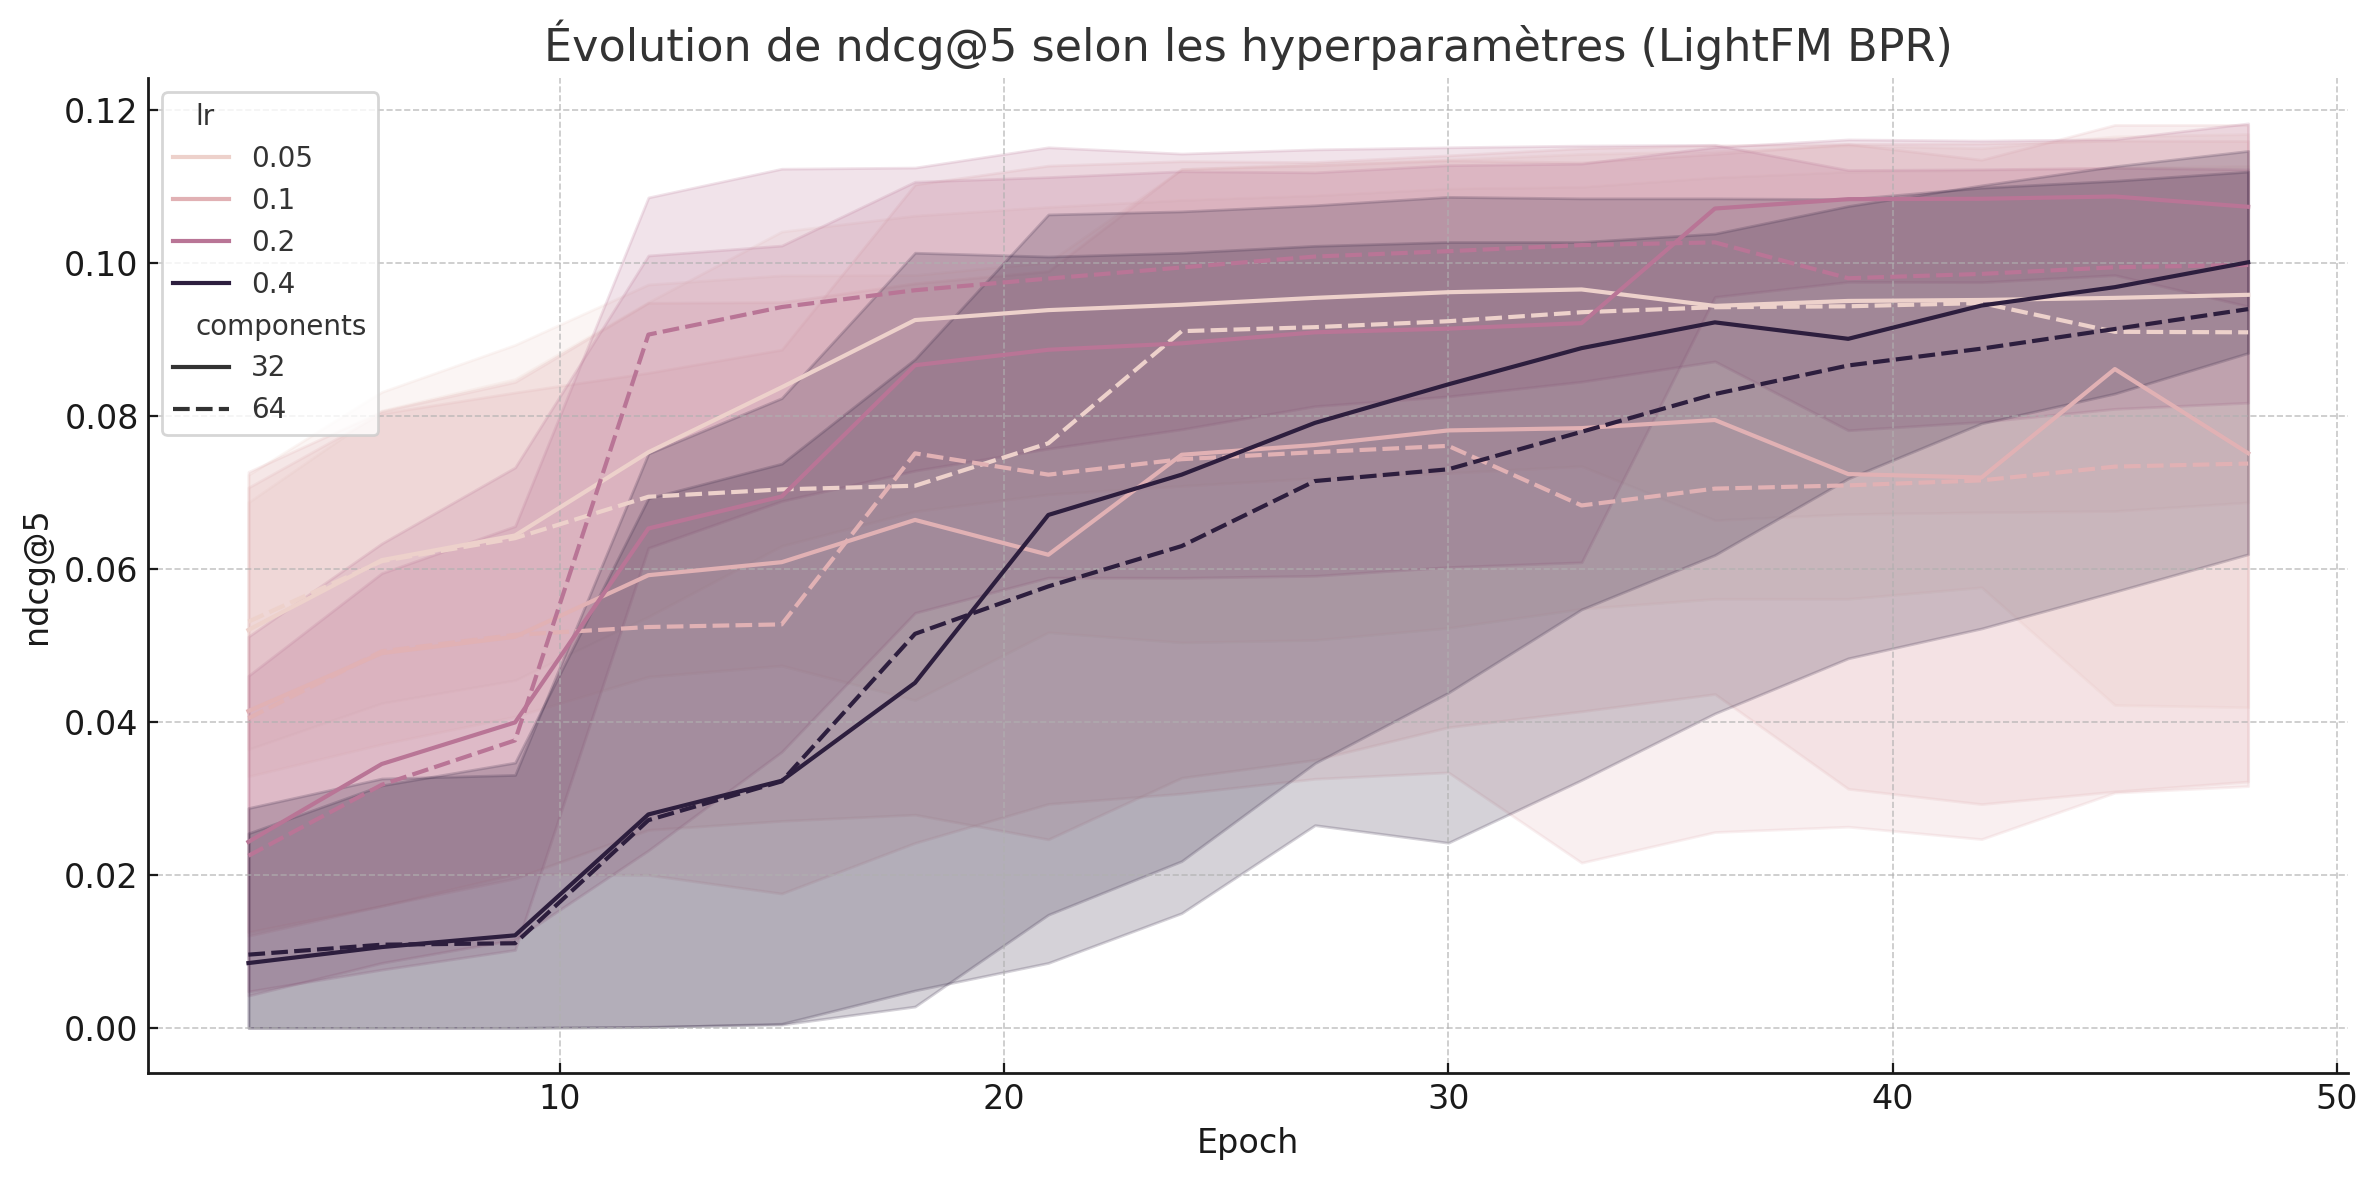

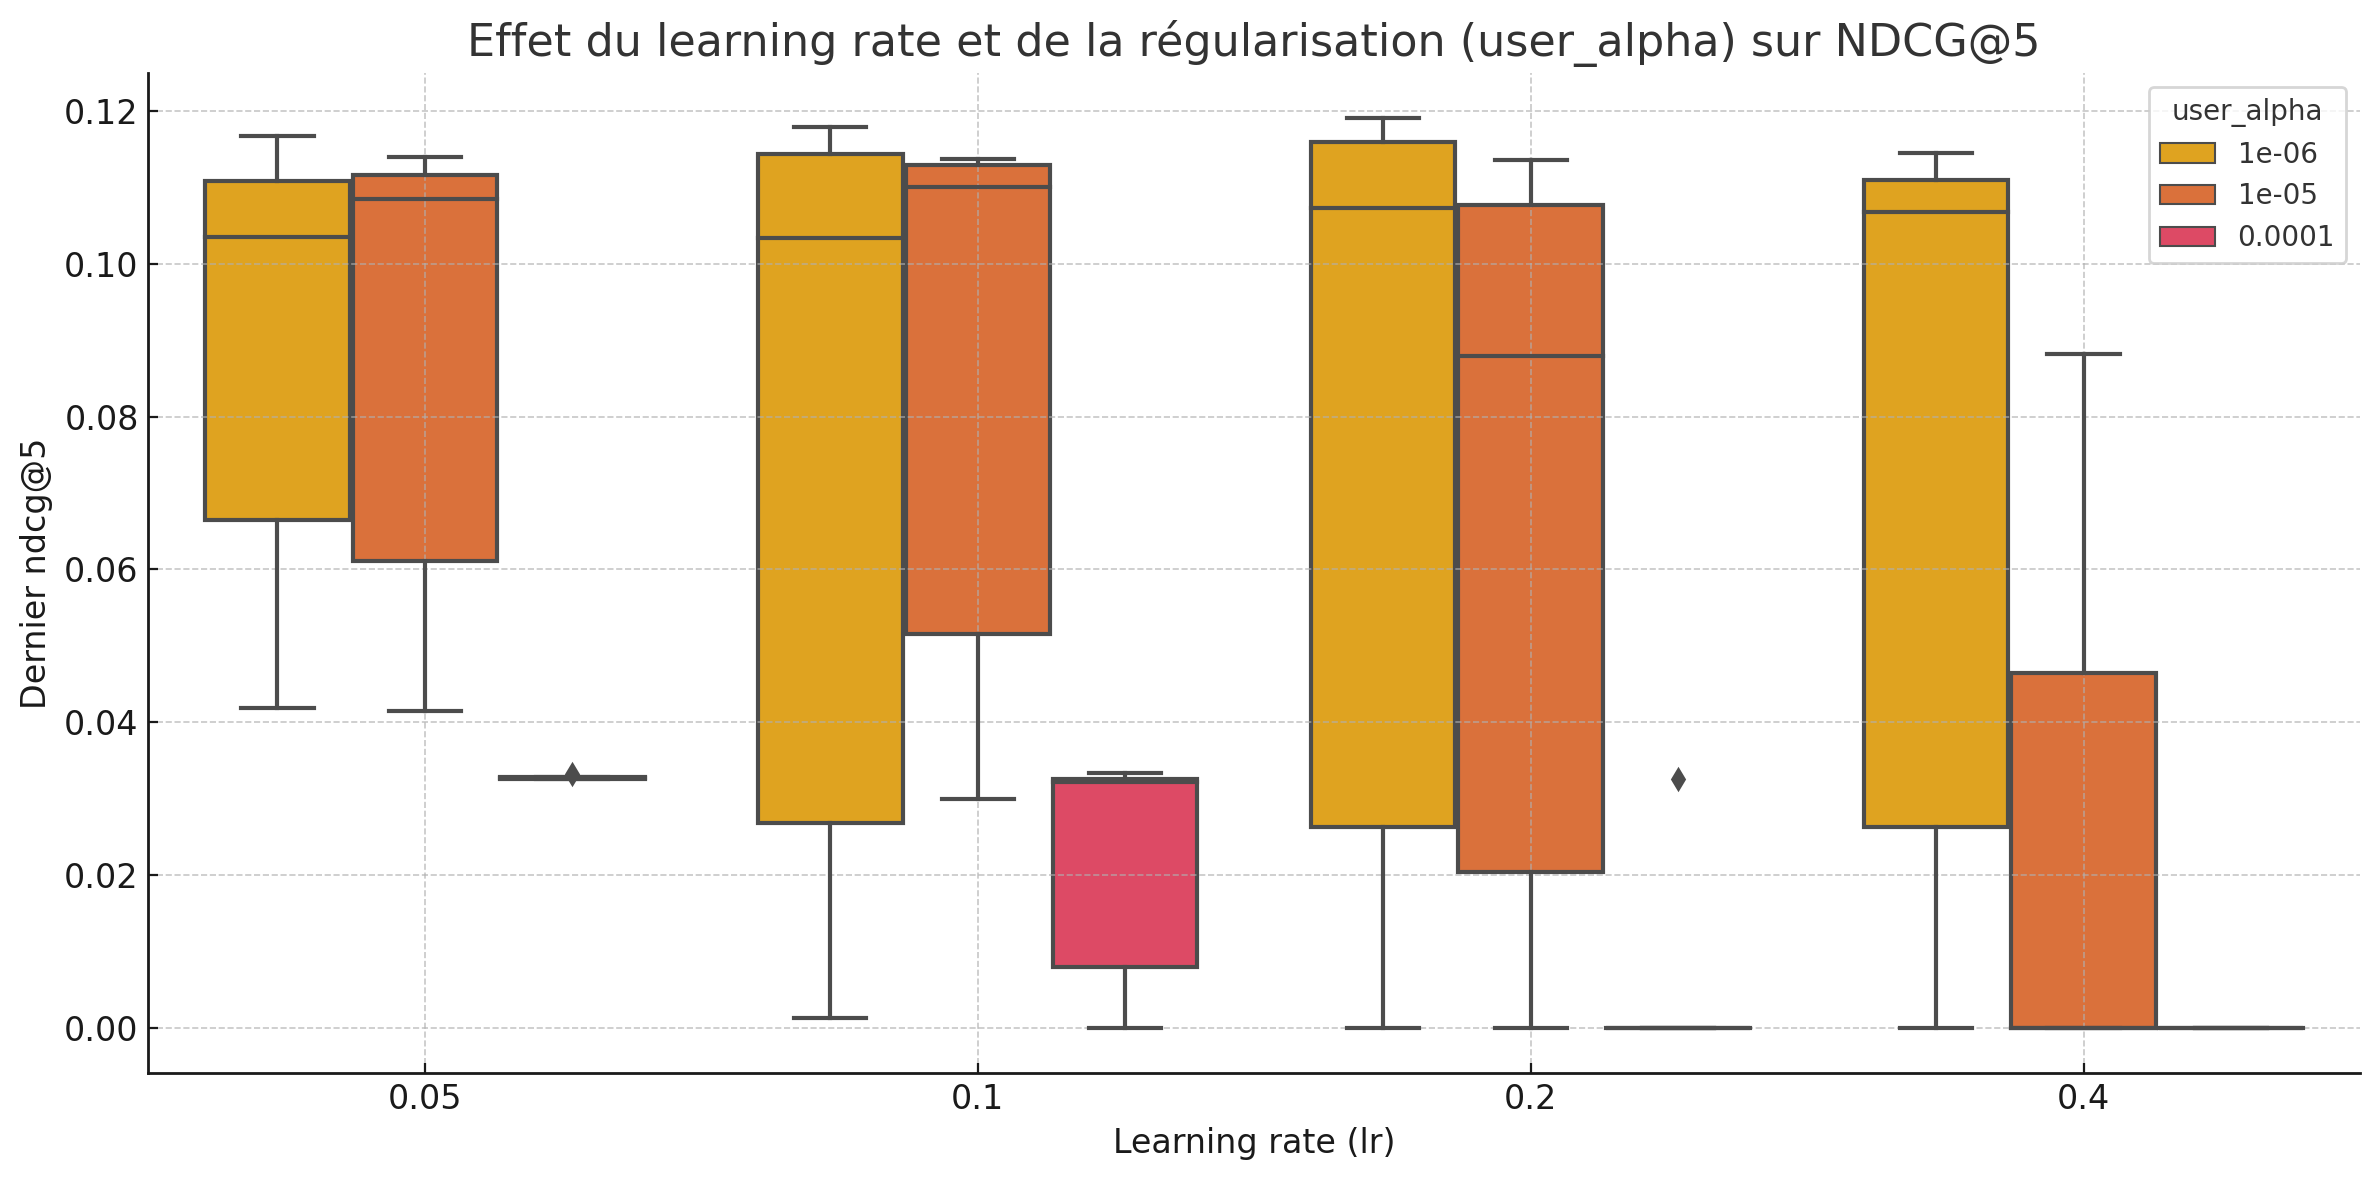

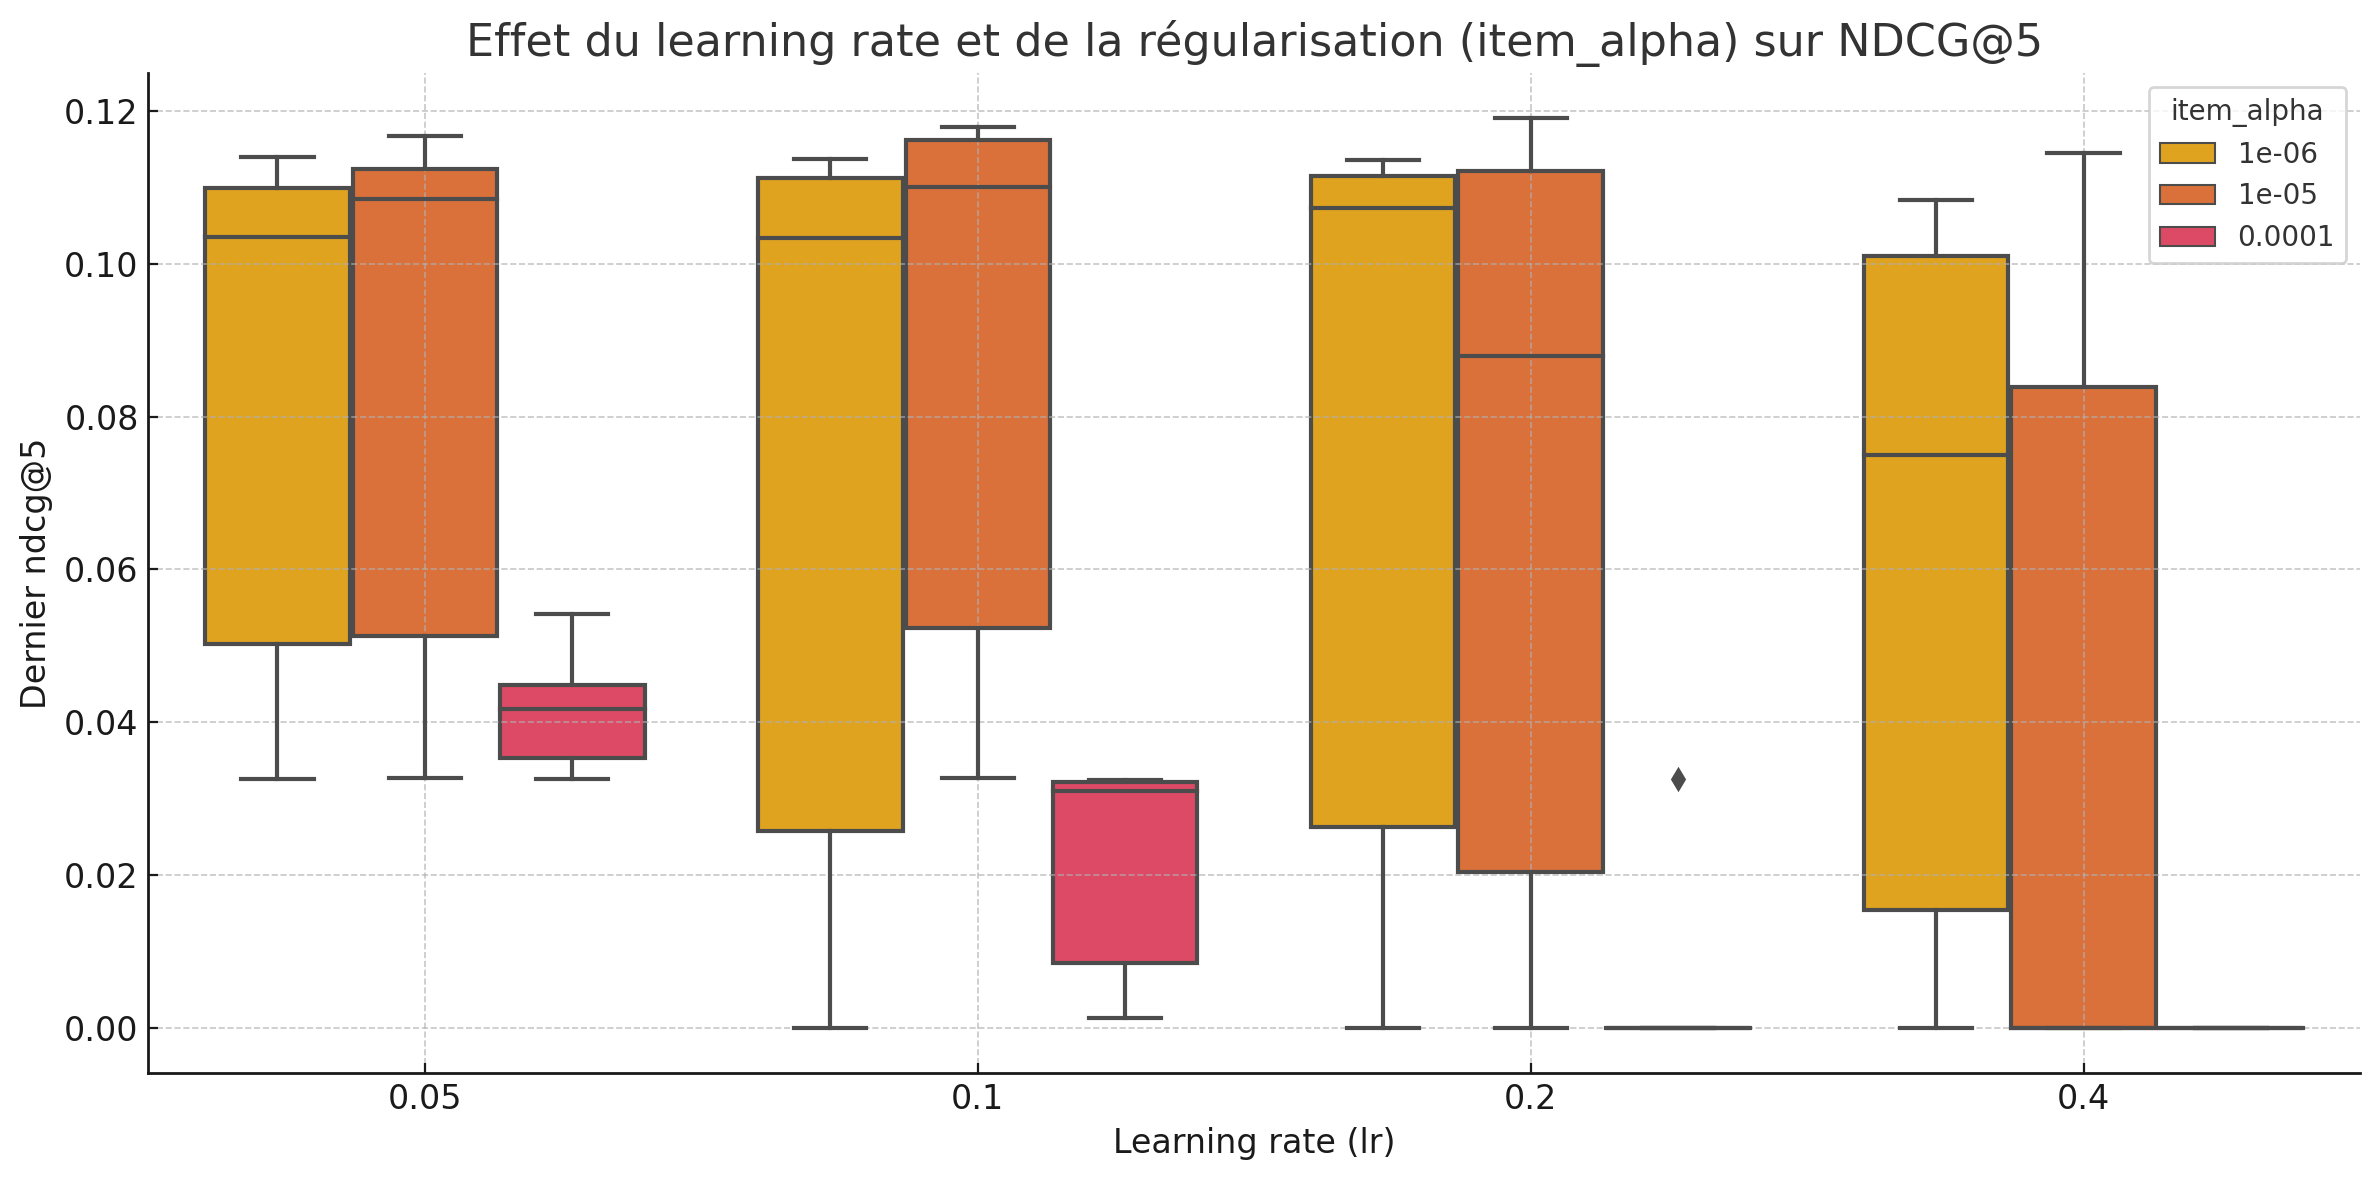

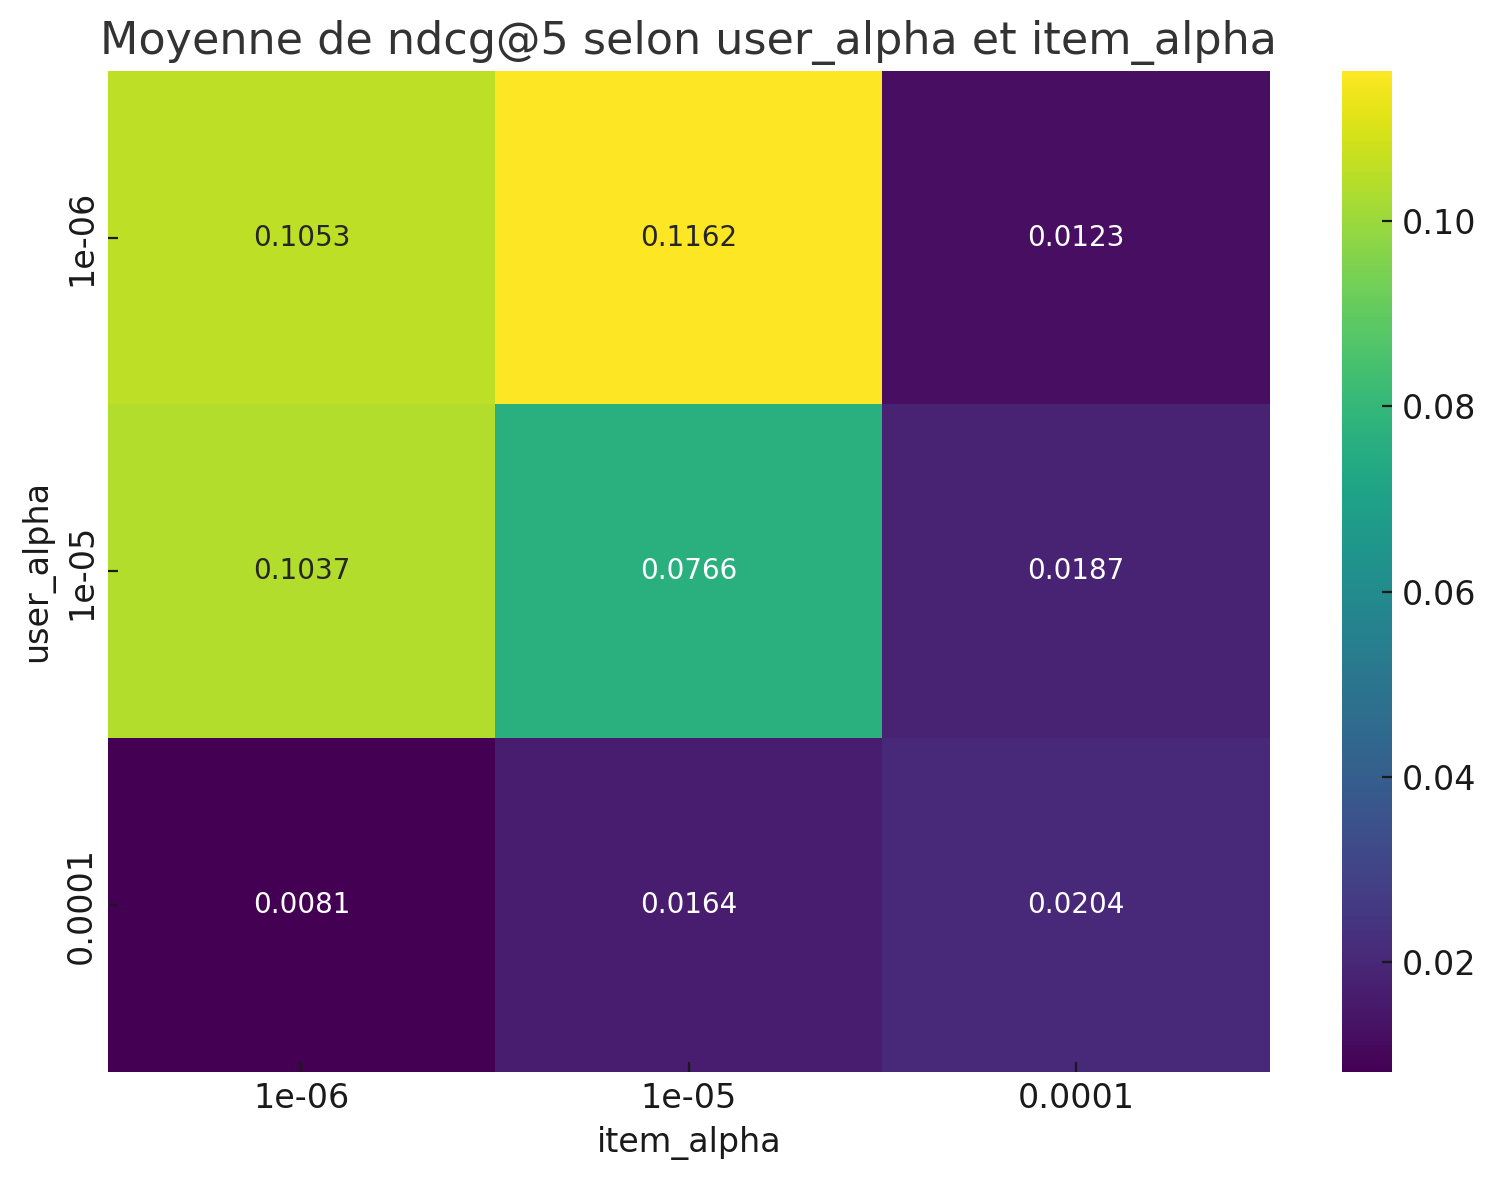

In [34]:
# Évaluation complète de ton meilleur modèle
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Métriques top-N
hit = precision_at_k(best_model, test_matrix, train_interactions=train_matrix, k=5).mean()
recall = recall_at_k(best_model, test_matrix, train_interactions=train_matrix, k=5).mean()
ndcg = ndcg_at_k(best_model, test_matrix, train_interactions=train_matrix, k=5)

# Erreurs de prédiction
rmse, mae = compute_rmse_mae(best_model, test_matrix, train_matrix)

# Caractéristiques de la matrice
n_users, n_articles = train_matrix.shape
n_interactions = train_matrix.nnz + test_matrix.nnz


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

Calcul RMSE/MAE (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

In [35]:
best_params

{'loss': 'bpr',
 'no_components': 64,
 'learning_rate': 0.2,
 'user_alpha': 1e-06,
 'item_alpha': 1e-05,
 'epoch': 30}

In [36]:
import pandas as pd

new_row = pd.DataFrame([{
    "modèle": f"LightFM grid_search best ({best_params['loss']}, "
              f"{best_params['no_components']}, "
              f"lr={best_params['learning_rate']}, "
              f"user_alpha={best_params['user_alpha']}, "
              f"item_alpha={best_params['item_alpha']})",
    "approche": "Collaborative Filtering (LightFM)",
    "n_users": n_users,
    "n_articles": n_articles,
    "n_interactions": n_interactions,
    "RMSE": rmse,
    "MAE": mae,
    "Hit@5": hit,
    "MAP@5": hit,  # approximation
    "NDCG@5": ndcg,
    "Precision@5": hit,
    "Recall@5": recall
}])


In [37]:
# Charger le fichier existant
eval_path = "./results/eval_results.csv"
df_eval = pd.read_csv(eval_path)

# Ajouter la nouvelle ligne
df_eval = pd.concat([df_eval, new_row], ignore_index=True)

# Sauvegarder
df_eval.to_csv(eval_path, index=False)
print("✅ Résultat LightFM ajouté à eval_results.csv")


✅ Résultat LightFM ajouté à eval_results.csv


In [38]:
# Meilleurs paramètres LightFM après grid_search
best_lightfm_params = {
    "loss": best_params["loss"],
    "no_components": best_params["no_components"],
    "learning_rate": best_params["learning_rate"],
    "user_alpha": best_params["user_alpha"],
    "item_alpha": best_params["item_alpha"],
    "epoch": best_params["epoch"],  # utile pour reprise/affichage
    "score": best_score,            # score sur la métrique choisie (ex: NDCG@5)
    "metric": "ndcg@5"              # ou "precision@5", selon ton choix
}

# Affichage lisible
print("🏆 Meilleurs hyperparamètres LightFM :")
for k, v in best_lightfm_params.items():
    print(f" - {k} : {v}")


🏆 Meilleurs hyperparamètres LightFM :
 - loss : bpr
 - no_components : 64
 - learning_rate : 0.2
 - user_alpha : 1e-06
 - item_alpha : 1e-05
 - epoch : 30
 - score : 0.1190997564040415
 - metric : ndcg@5


### Ré-entrainement du meilleur modèle

In [39]:
import os
import pandas as pd
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from tqdm.notebook import tqdm

#### 🎯 Entrainement avec les paramètres optimaux

In [12]:
from lightfm import LightFM
from tqdm.notebook import tqdm  # ✅ pour un affichage propre dans notebook

def train_lightfm_model(train_matrix,
                        best_params,
                        user_features=None,
                        item_features=None,
                        valid_matrix=None,
                        metric="ndcg",
                        k=5,
                        num_threads=8,
                        max_epochs=50,
                        eval_every=5,
                        patience=3):
    """
    Entraîne un modèle LightFM avec early stopping intégré (compatible notebook),
    incluant régularisation utilisateur/article si spécifiée.
    """
    model = LightFM(
        loss=best_params["loss"],
        no_components=best_params["no_components"],
        learning_rate=best_params["learning_rate"],
        user_alpha=best_params.get("user_alpha", 0.0),
        item_alpha=best_params.get("item_alpha", 0.0),
        random_state=42
    )

    best_score = -float("inf")
    best_epoch = 0
    no_improve = 0

    for epoch in tqdm(range(1, max_epochs + 1), desc="⏳ Entraînement LightFM"):
        model.fit_partial(train_matrix,
                          user_features=user_features,
                          item_features=item_features,
                          epochs=1,
                          num_threads=num_threads)

        if valid_matrix is not None and epoch % eval_every == 0:
            if metric == "ndcg":
                score = ndcg_at_k(model, valid_matrix, train_matrix,
                                  user_features=user_features,
                                  item_features=item_features,
                                  k=k, num_threads=num_threads)
            elif metric == "precision":
                from lightfm.evaluation import precision_at_k
                score = precision_at_k(model, valid_matrix, train_interactions=train_matrix,
                                       user_features=user_features,
                                       item_features=item_features,
                                       k=k, num_threads=num_threads).mean()
            else:
                raise ValueError("❌ Metric non supportée")

            print(f"📉 Epoch {epoch} — {metric}@{k} = {score:.4f}")

            if score > best_score:
                best_score = score
                best_epoch = epoch
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"🛑 Early stopping (aucune amélioration depuis {patience} évaluations)")
                    break

    print(f"✅ Meilleur score à l'epoch {best_epoch} : {metric}@{k} = {best_score:.4f}")
    return model


#### 🎯 Evaluation

In [24]:
import numpy as np
import os
import pandas as pd
from lightfm.evaluation import precision_at_k, recall_at_k

def evaluate_lightfm_model_to_eval_results(model,
                                           train_matrix,
                                           test_matrix,
                                           best_params,
                                           experiment,
                                           user_features=None,
                                           item_features=None,
                                           k=5,
                                           num_threads=8,
                                           results_file="results/eval_results.csv"):
    """
    Évalue un modèle LightFM avec top-K + erreurs de prédiction et ajoute les résultats à eval_results.csv,
    incluant les paramètres de régularisation dans l’identifiant du modèle.
    """

    # 🔸 Top-K
    hit = precision_at_k(model, test_matrix, train_interactions=train_matrix,
                         user_features=user_features,
                         item_features=item_features,
                         k=k, num_threads=num_threads).mean()

    recall = recall_at_k(model, test_matrix, train_interactions=train_matrix,
                         user_features=user_features,
                         item_features=item_features,
                         k=k, num_threads=num_threads).mean()

    # 🔸 NDCG
    ndcg = ndcg_at_k(model, test_matrix, train_interactions=train_matrix,
                     user_features=user_features,
                     item_features=item_features,
                     k=k, num_threads=num_threads)

    # 🔸 Erreurs de prédiction
    rmse, mae = compute_rmse_mae_normalized(model, test_matrix, train_interactions=train_matrix,
                                 user_features=user_features,
                                 item_features=item_features,
                                 num_threads=num_threads)

    # 📦 Dimensions globales
    n_users, n_articles = train_matrix.shape
    n_interactions = train_matrix.nnz + test_matrix.nnz

    # 🔖 Création du label du modèle avec régularisation
    experiment_clean = experiment.strip()
    user_alpha = best_params.get('user_alpha', 0.0)
    item_alpha = best_params.get('item_alpha', 0.0)

    model_label = (
        f"{experiment_clean}, ({best_params['loss']}, {best_params['no_components']}, "
        f"lr={best_params['learning_rate']}, u_reg={user_alpha}, i_reg={item_alpha})"
    )

    # 🧾 Ligne à ajouter
    result_row = pd.DataFrame([{
        "modèle": model_label,
        "approche": "LightFM",
        "n_users": n_users,
        "n_articles": n_articles,
        "n_interactions": n_interactions,
        "RMSE": rmse,
        "MAE": mae,
        "Hit@5": hit,
        "MAP@5": hit,
        "NDCG@5": ndcg,
        "Precision@5": hit,
        "Recall@5": recall
    }])

    # 💾 Sauvegarde CSV
    os.makedirs(os.path.dirname(results_file), exist_ok=True)
    if os.path.exists(results_file):
        df_existing = pd.read_csv(results_file)
        df_combined = pd.concat([df_existing, result_row], ignore_index=True)
        df_combined = df_combined.drop_duplicates()
    else:
        df_combined = result_row

    df_combined.to_csv(results_file, index=False)
    print(f"✅ Résultat ajouté à {results_file}")

    return result_row


#### 🎯 Résultat avec matrice utilisateur-item

In [15]:
# Resultat du grid_search lightfm (CF pur)
best_lightfm_params = {'loss': 'bpr',
                     'no_components': 64,
                     'learning_rate': 0.2,
                     'user_alpha': 1e-06,
                     'item_alpha': 1e-05,
                     'epoch': 30}
# Extraction des hyperparamètres LightFM uniquement
lightfm_hyperparams = {
    "loss": best_lightfm_params["loss"],
    "no_components": best_lightfm_params["no_components"],
    "learning_rate": best_lightfm_params["learning_rate"],
    "user_alpha": best_lightfm_params.get("user_alpha", 0.0),
    "item_alpha": best_lightfm_params.get("item_alpha", 0.0)
}

In [17]:
# Entraînement final du modèle
model_final = train_lightfm_model(
    train_matrix=train_matrix,
    best_params=lightfm_hyperparams,
    user_features=None,
    item_features=None,
    valid_matrix=test_matrix,  
    metric="ndcg",             # ou "precision" 
    k=5,
    num_threads=8,
    max_epochs=50,
    eval_every=3,  
    patience=2 # ✅ early stopping
)


⏳ Entraînement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 3 — ndcg@5 = 0.0654


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 6 — ndcg@5 = 0.0962


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 9 — ndcg@5 = 0.1066


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 12 — ndcg@5 = 0.1121


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.1148


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 18 — ndcg@5 = 0.1167


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 21 — ndcg@5 = 0.1181


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 24 — ndcg@5 = 0.1190


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 27 — ndcg@5 = 0.1192


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.1190


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 33 — ndcg@5 = 0.1190
🛑 Early stopping (aucune amélioration depuis 2 évaluations)
✅ Meilleur score à l'epoch 27 : ndcg@5 = 0.1192


In [44]:
results = evaluate_lightfm_model_to_eval_results(
    model=model_final,
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    best_params=lightfm_hyperparams,
    experiment="User-item best retrain",
    user_features=None,
    item_features=None,
    k=5,
    num_threads=8
)

print(results)

Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

Calcul RMSE/MAE (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

✅ Résultat ajouté à results/eval_results.csv
                                              modèle approche  n_users  \
0  User-item best retrain, (bpr, 64, lr=0.2, u_re...  LightFM   221379   

   n_articles  n_interactions      RMSE       MAE     Hit@5     MAP@5  \
0       41367         2747674  1.840077  1.639087  0.034954  0.034954   

     NDCG@5  Precision@5  Recall@5  
0  0.119593     0.034954  0.174768  


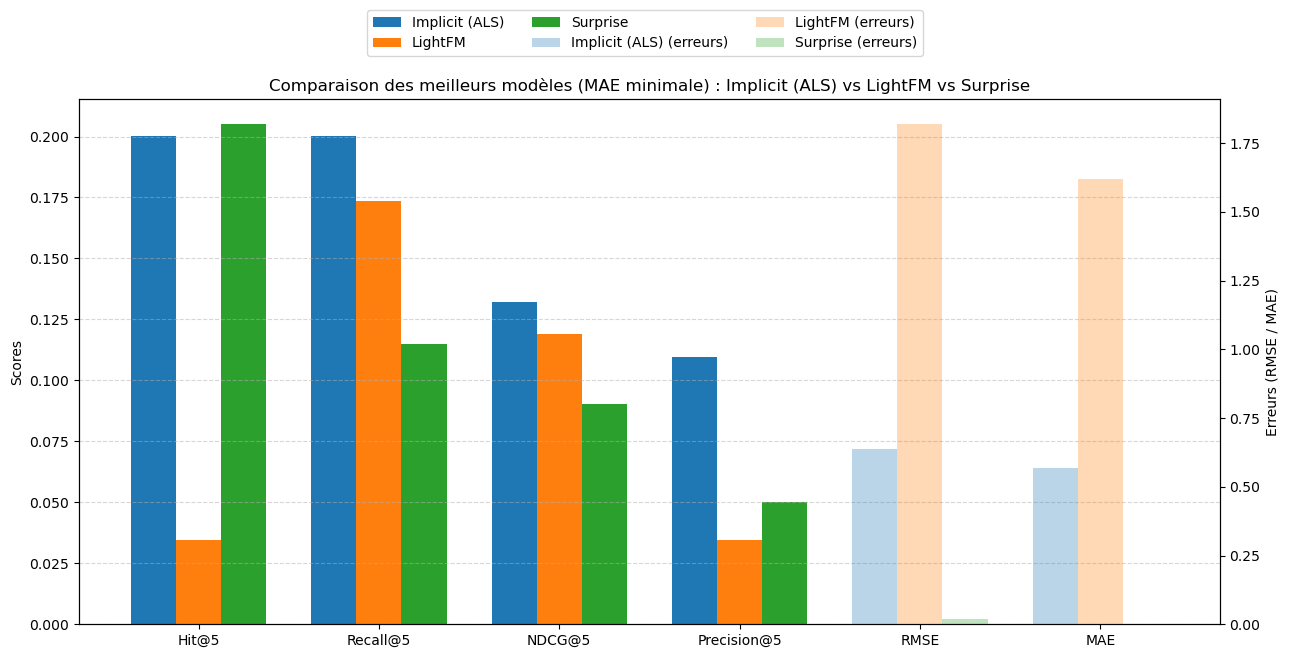

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Chargement
df = pd.read_csv("./results/eval_results.csv")

# Extraction des meilleurs modèles
best_implicit = df[df["modèle"].str.contains("AlternatingLeastSquares")].sort_values("MAE", ascending=True).iloc[0]
best_lightfm = df[df["modèle"].str.contains("LightFM")].sort_values("MAE", ascending=True).iloc[0]
best_surprise = df[df["approche"].str.contains("Surprise")].sort_values("MAE", ascending=True).iloc[0]

# Métriques
main_metrics = ["Hit@5", "Recall@5", "NDCG@5", "Precision@5"]
secondary_metrics = ["RMSE", "MAE"]
labels = main_metrics + secondary_metrics
x = range(len(labels))
width = 0.25

# Données
vals_implicit = [best_implicit[m] for m in labels]
vals_lightfm = [best_lightfm[m] for m in labels]
vals_surprise = [best_surprise[m] for m in labels]

# Graphique
fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()

# Scores
for vals, label, color, offset in [
    (vals_implicit, "Implicit (ALS)", "#1f77b4", -width),
    (vals_lightfm, "LightFM", "#ff7f0e", 0),
    (vals_surprise, "Surprise", "#2ca02c", width)
]:
    ax1.bar([i + offset for i in range(len(main_metrics))],
            [vals[i] for i in range(len(main_metrics))],
            width=width, label=label, color=color)
    ax2.bar([i + offset + len(main_metrics) for i in range(len(secondary_metrics))],
            [vals[i + len(main_metrics)] for i in range(len(secondary_metrics))],
            width=width, label=f"{label} (erreurs)", color=color, alpha=0.3)

# Mise en forme
ax1.set_xticks(list(x))
ax1.set_xticklabels(labels)
ax1.set_ylabel("Scores")
ax2.set_ylabel("Erreurs (RMSE / MAE)")
ax1.set_title("Comparaison des meilleurs modèles (MAE minimale) : Implicit (ALS) vs LightFM vs Surprise")
ax1.grid(axis='y', linestyle='--', alpha=0.5)
fig.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.show()


✅ Résumé du setup : <br>
- ⚙️ Modèle : LightFM (avec ou sans features)
- 📊 Métriques :
    - precision_at_k, recall_at_k (LightFM natif)
    - ndcg_at_k, rmse, mae (custom, full Numpy + Joblib, optimisé)
- 🔁 Évaluation complète sur tout le dataset
- ⚡ Temps total d’évaluation : ≈ 10 minutes
- 💾 Résultats loggés proprement dans un fichier CSV

Au niveau résultat LightFM est  en-dessous de Implicit avec ALS optimisé, même en prenant toutes les précautions pour préserver la force du signal, limiter les outliers, écarter les utilisateurs peu informatifs, pas de normalisation. <br>
Ca peut être du à un manque d'enrichissement sémantique via les features utilisateurs ou articles. Aussi WARP/BPR de LigthfM suppose des comparaisons implicites binaires, hors les poids sont ici continus, enfin la taille de la matrice ! <br>
Les valeurs RMSE et MAE ne doivent pas être le critère pour le choix de l'approche, elles ne sont pertinentes que pour les scores explicites (ici ce sont des erreurs par paire).<br>
Il n'est pas toujours visé de prédire exactement (hits) mais d'avoir les bon items en tête, NDCG est alors la métrique pertinente.

In [18]:
from lightfm import LightFM
import numpy as np
import os

## Non utilisé ne fonctionne pas avec load_model (demande un fit)
# def save_lightfm_model(model, path="./models/lightfm_model.npz"):
#     os.makedirs(os.path.dirname(path), exist_ok=True)
#     model_data = {
#         "item_embeddings": model.item_embeddings,
#         "user_embeddings": model.user_embeddings,
#         "item_biases": model.item_biases,
#         "user_biases": model.user_biases,
#         "params": model.get_params()
#     }
#     np.savez_compressed(path, **model_data)
#     print(f"✅ Modèle LightFM sauvegardé dans {path}")

import pickle
import os

def save_lightfm_pickle(model, path="./models/lightfm_model.pkl"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump(model, f)
    print(f"✅ Modèle LightFM sauvegardé dans {path}")


In [19]:
save_lightfm_pickle(model_final, path="./reco-mvp/model/lightfm_model_user_item.pkl")

✅ Modèle LightFM sauvegardé dans ./reco-mvp/model/lightfm_model_user_item.pkl


## Première approche hybride: Item features (embeddingd puis information de clics)
🧩 Étape 2 — Les embeddings des articles sont très informatifs on les introduit comme item_features. Le modèle ne verra pas les non-cliqués<br>
💡 Tester la combinaison de la matrice user_item non normalisé avec les embeddings également non normalisés en espérant que lightFM arrivera à capter et combiner les deux sources d'informations lors de la factorisation

### Construction de la matrice item features embeddings

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Charger les embeddings (index = article_id)
embeddings_df = pd.read_parquet("./data/articles_embeddings_pca.parquet")
embeddings_df.index.name = "article_id"

In [9]:
# Avant toute normalisation il faut filtrer
# Créer la liste ordonnée des article_ids utilisés dans la matrice user-item
ordered_article_ids = [aid for aid, _ in sorted(item_mapping.items(), key=lambda x: x[1])]

# Filtrer les embeddings pour ne garder que ceux présents dans item_mapping
embeddings_df_filtered = embeddings_df.loc[embeddings_df.index.intersection(ordered_article_ids)]

# Réordonner pour correspondre strictement à item_mapping
embeddings_df_filtered = embeddings_df_filtered.loc[ordered_article_ids]

In [10]:
from sklearn.preprocessing import normalize

# Normalisation L2 des vecteurs (chaque ligne)
embeddings_normalized = normalize(embeddings_df_filtered, norm="l2", axis=1)

# Conversion en DataFrame avec mêmes index/colonnes
embeddings_df_normalized = pd.DataFrame(
    embeddings_normalized,
    index=embeddings_df_filtered.index,
    columns=embeddings_df_filtered.columns
)

# Sauvegarde (si besoin)
embeddings_df_normalized.to_parquet("articles_embeddings_pca_filtered_normalized.parquet")

In [11]:
embeddings_df_normalized

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
article_id,,,,,,,,,,,,,,,,,,,,,
68866,0.337074,0.161814,-0.303480,0.320910,-0.021610,0.266760,0.200751,-0.280029,-0.203450,-0.168596,...,-0.072756,0.057962,-0.035777,-0.022230,-0.095057,0.025730,0.050654,-0.035347,0.001251,-0.113606
87205,0.666061,-0.206220,0.174248,0.026067,-0.000734,-0.309923,0.103950,-0.127303,0.029193,0.134414,...,-0.246723,0.057828,0.045427,0.060003,0.007531,-0.072838,-0.057685,0.041696,0.052638,-0.043400
87224,0.799295,0.005616,0.207364,0.151673,-0.097152,-0.202503,-0.122100,-0.044804,0.333249,-0.045518,...,0.015147,-0.152555,0.021617,0.030750,0.074127,0.024366,0.079173,-0.054821,-0.006604,-0.100124
96755,0.102214,-0.112103,-0.141209,0.016697,0.018852,0.316574,0.286397,-0.591907,0.104758,-0.023697,...,0.038451,-0.069473,-0.039546,0.002697,-0.091012,-0.050929,0.028645,0.212898,0.036964,-0.063012
157541,0.309866,0.338222,-0.386221,0.283509,0.015701,0.284942,0.074527,-0.236329,-0.300462,0.011073,...,-0.019894,0.056324,-0.025558,0.042132,-0.025893,-0.032578,0.018913,-0.019048,-0.037524,-0.040259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154578,0.440999,0.635580,-0.153953,-0.043207,0.137994,0.026182,-0.001366,-0.196612,-0.279122,0.039226,...,0.025773,-0.042694,-0.044189,0.095633,-0.004985,-0.054630,-0.076470,-0.043166,0.107388,0.068729
180346,-0.125580,0.400876,-0.400133,-0.139200,0.024778,-0.373649,0.043064,-0.239197,-0.086140,-0.116611,...,0.044259,0.211584,-0.151947,0.145302,0.195717,-0.056998,-0.038615,-0.187310,0.101248,-0.043657
272563,-0.073474,-0.237872,-0.304741,0.120750,-0.003001,-0.024495,0.134553,0.377020,0.209195,0.074884,...,0.100462,-0.015550,0.050169,-0.051347,-0.029152,0.033991,0.101698,0.090260,-0.080711,-0.010495


In [12]:
expected_shape = (len(item_mapping), embeddings_df.shape[1])
actual_shape = embeddings_df_normalized.shape

assert actual_shape == expected_shape, f"❌ Shape incorrecte : attendu {expected_shape}, obtenu {actual_shape}"
print("✅ Shape des embeddings conforme :", actual_shape)


✅ Shape des embeddings conforme : (41367, 41)


In [13]:
from scipy.sparse import csr_matrix

item_features = csr_matrix(embeddings_df_normalized.values)

### Sous-échantillonage des users

In [23]:
def train_lightfm_fast_sample(train_matrix,
                              item_features=None,
                              user_features=None,
                              best_params=None,
                              sample_users=None,
                              valid_matrix=None,
                              metric="ndcg",
                              k=5,
                              max_epochs=30,
                              eval_every=5,
                              patience=3,
                              use_identity_features=True):
    """
    Entraîne un modèle LightFM sur un sous-échantillon de la matrice utilisateur-item pour test rapide,
    avec early stopping basé sur ndcg_at_k.

    - item_features et user_features sont optionnels (None = non utilisés)
    - use_identity_features permet de désactiver les features implicites pour les items
    """
    from tqdm.notebook import tqdm
    from lightfm import LightFM

    if sample_users is not None:
        train_matrix = train_matrix[sample_users]
        if valid_matrix is not None:
            valid_matrix = valid_matrix[sample_users]
        if user_features is not None:
            user_features = user_features[sample_users]

    model = LightFM(
        loss=best_params["loss"],
        no_components=best_params["no_components"],
        learning_rate=best_params["learning_rate"],
        user_alpha=best_params.get("user_alpha", 0.0),
        item_alpha=best_params.get("item_alpha", 0.0),
        random_state=42
    )

    if not use_identity_features:
        model._item_identity_features = False

    best_score = -float("inf")
    best_epoch = 0
    no_improve = 0

    for epoch in tqdm(range(1, max_epochs + 1), desc="⚡ Fast LightFM"):
        model.fit_partial(train_matrix,
                          item_features=item_features,
                          user_features=user_features,
                          epochs=1,
                          num_threads=4)

        if valid_matrix is not None and epoch % eval_every == 0:
            if metric == "ndcg":
                score = ndcg_at_k(model, valid_matrix,
                                  train_interactions=train_matrix,
                                  item_features=item_features,
                                  user_features=user_features,
                                  k=k, num_threads=4)
            else:
                raise ValueError("❌ Seule la métrique 'ndcg' est supportée ici.")

            print(f"📉 Epoch {epoch} — {metric}@{k} = {score:.4f}")

            if score > best_score:
                best_score = score
                best_epoch = epoch
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"🛑 Early stopping (aucune amélioration depuis {patience} évaluations)")
                    break

    print(f"✅ Meilleur score à l'epoch {best_epoch} : {metric}@{k} = {best_score:.4f}")
    return model


In [20]:
import numpy as np
# A faire une seule fois si on veut vraiment comparer
sample_users = np.random.choice(train_matrix.shape[0], 5000, replace=False)

# Test d'entrainement échantilloné avec les meilleurs paramètres de lightfm en mode CF
# Baseline de sample: matrice user-item seule

model_fast = train_lightfm_fast_sample(
    train_matrix=train_matrix,
    item_features=None,
    best_params=lightfm_hyperparams,
    sample_users=sample_users,
    valid_matrix=test_matrix,
    max_epochs=100,
    patience=5
)

⚡ Fast LightFM:   0%|          | 0/100 [00:00<?, ?it/s]

Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0683


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0712


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0706


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0679


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0698


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0698


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0709
🛑 Early stopping (aucune amélioration depuis 5 évaluations)
✅ Meilleur score à l'epoch 10 : ndcg@5 = 0.0712


### Entrainement et évaluation user-item avec item features (embeddings)

In [21]:
model_fast_hybrid = train_lightfm_fast_sample(
    train_matrix=train_matrix,
    item_features=item_features,  # ajout de la matrice des embeddings
    best_params=lightfm_hyperparams,
    sample_users=sample_users,
    valid_matrix=test_matrix,
    use_identity_features=False,  # 🔥 pour utiliser uniquement les embeddings
    max_epochs=50,
    patience=3
)

⚡ Fast LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0027


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0024


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0022


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0024
🛑 Early stopping (aucune amélioration depuis 3 évaluations)
✅ Meilleur score à l'epoch 5 : ndcg@5 = 0.0027


Même en ayant fait un centrage-normalisation des embeddings, focalisé le calcul sur les embeddings la dégradation des résultats est notable lorsqu'on complexifie le problème en ajoutant les données articles.<br>
Il est probable que les paramètres optmisés sans features ne sont plus adaptés. Il faut prendre en compte que l'apprentissage est différent: lorsqu'on fournit des item features les poids des items ne sont plus appris directement. LightFM apprend uniquement des poids sur les features cela signifie que chaque item devient une "somme pondérée" de ses features, mais si ce n'est pas alignés sur les préférences utilisateurs la performance peut rester mauvaise.

## Ajout des clicks features aux embeddings d'articles

### Chargement et préparation des données articles
La matrice user-item ne contient que les articles cliqués. Pour le MVP on va s'en contenter. Lorsqu'on voudra pouvoir traiter le cold start article il faudra reconstruire la matrice user-item avec des interactions négatives pour les articles non cliqués.<br>
La catégorie est peu exploitable, la variable a été peu explorée, elle est distribué sur 460 valeurs, le one-hot exploserait les dimensions.

In [24]:
# Datas articles d'origine
import pandas as pd
df_articles = pd.read_csv("./data/articles_metadata.csv", encoding='utf-8')
articles_df = df_articles.drop(columns=["publisher_id", "category_id"])

In [25]:
# Filtrage et réordonnancement selon item_mapping
ordered_article_ids = [aid for aid, _ in sorted(item_mapping.items(), key=lambda x: x[1])]

# Vérification de présence
available_ids = set(articles_df['article_id'])
missing_ids = [aid for aid in ordered_article_ids if aid not in available_ids]

if missing_ids:
    print(f"⚠️ {len(missing_ids)} articles manquants dans articles_df.")
    ordered_article_ids = [aid for aid in ordered_article_ids if aid in available_ids]
else:
    print("✅ Tous les articles de item_mapping sont présents dans articles_df.")

# Filtrage + tri
articles_df_filtered = articles_df.set_index('article_id').loc[ordered_article_ids].reset_index()

✅ Tous les articles de item_mapping sont présents dans articles_df.


In [26]:
articles_df_filtered

,article_id,created_at_ts,words_count
0,68866,1506816482000,226
1,87205,1507497786000,137
2,87224,1507496527000,100
3,96755,1507326628000,211
4,157541,1506800518000,280
...,...,...,...
41362,154578,1457730467000,207
41363,180346,1478175654000,227
41364,272563,1505385425000,200
41365,65226,1474649856000,229


#### 📌 1: Normalisation de words count

In [27]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_words_count(articles_df):
    """
    Applique une transformation log1p + MinMaxScaler à la colonne words_count.
    Retourne un DataFrame avec article_id et la feature normalisée.
    """
    words_df = articles_df[['article_id', 'words_count']].copy()
    words_df['words_count'] = np.log1p(words_df['words_count'])  # réduction de skew
    words_df['words_count'] = MinMaxScaler().fit_transform(words_df[['words_count']])  # normalisation 0-1
    return words_df

In [28]:
words_count_normalized = normalize_words_count(articles_df_filtered)
words_count_normalized

,article_id,words_count
0,68866,0.657959
1,87205,0.597596
2,87224,0.559740
3,96755,0.649667
4,157541,0.683841
...,...,...
41362,154578,0.647357
41363,180346,0.658492
41364,272563,0.643205
41365,65226,0.659551


#### 📌 2: Features relatifs aux clics

In [29]:
# 1. Features d'usage à partir de df_clicks
click_stats = df_clicks.groupby('click_article_id').agg(
    num_clicks=('user_id', 'size'),
    num_users_clicked=('user_id', 'nunique'),
    last_click_timestamp=('click_timestamp', 'max'),
    first_click_timestamp=('click_timestamp', 'min')
)

In [30]:
def extract_click_usage_features(click_stats, articles_df, df_clicks):
    stats_df = click_stats.copy()

    # Span en heures
    stats_df["click_span_hours"] = (stats_df["last_click_timestamp"] - stats_df["first_click_timestamp"]) / (1000 * 3600)

    # Premier clic global
    first_global_click = pd.to_datetime(df_clicks["click_timestamp"].min(), unit='ms')
    articles_temp = articles_df[["article_id", "created_at_ts"]].copy()
    articles_temp["created_at"] = pd.to_datetime(articles_temp["created_at_ts"], unit='ms')
    articles_temp["delta_days_since_pub"] = (first_global_click - articles_temp["created_at"]).dt.total_seconds() / (3600 * 24)

    # Préparation
    stats_df = stats_df.reset_index().rename(columns={"click_article_id": "article_id"})
    merged_df = stats_df.merge(articles_temp[["article_id", "delta_days_since_pub"]], on="article_id", how="left")

    # Transformations adaptées
    merged_df["num_clicks"] = np.log1p(merged_df["num_clicks"])
    merged_df["num_users_clicked"] = np.log1p(merged_df["num_users_clicked"])
    # Pas de log sur les variables temporelles
    # (click_span_hours et delta_days_since_pub)

    # Normalisation
    scaler = MinMaxScaler()
    cols = ["num_clicks", "num_users_clicked", "click_span_hours", "delta_days_since_pub"]
    merged_df[cols] = scaler.fit_transform(merged_df[cols])

    # Réordonnancement explicite selon item_mapping
    ordered_article_ids = [aid for aid, _ in sorted(item_mapping.items(), key=lambda x: x[1])]
    merged_df = merged_df.set_index('article_id').loc[ordered_article_ids].reset_index()

    return merged_df[["article_id"] + cols]


In [31]:
article_clicks_features = extract_click_usage_features(click_stats, articles_df_filtered, df_clicks)
article_clicks_features

,article_id,num_clicks,num_users_clicked,click_span_hours,delta_days_since_pub
0,68866,0.673435,0.678764,0.103516,0.011187
1,87205,0.662273,0.667355,0.417789,0.009207
2,87224,0.793485,0.798946,0.548621,0.009211
3,96755,0.813832,0.820379,0.410894,0.009705
4,157541,0.530719,0.534286,0.767190,0.011234
...,...,...,...,...,...
41362,154578,0.000000,0.000000,0.000000,0.153841
41363,180346,0.000000,0.000000,0.000000,0.094423
41364,272563,0.000000,0.000000,0.000000,0.015346
41365,65226,0.000000,0.000000,0.000000,0.104670


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(item_features_df, feature_columns):
    """
    Affiche les histogrammes des colonnes normalisées de item_features_df.
    
    Paramètres :
        item_features_df (pd.DataFrame) : DataFrame contenant article_id + features normalisées
        feature_columns (list[str]) : Liste des noms de colonnes à tracer
    """
    num_features = len(feature_columns)
    fig, axes = plt.subplots(1, num_features, figsize=(4 * num_features, 4))

    if num_features == 1:
        axes = [axes]

    for ax, col in zip(axes, feature_columns):
        sns.histplot(item_features_df[col], bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


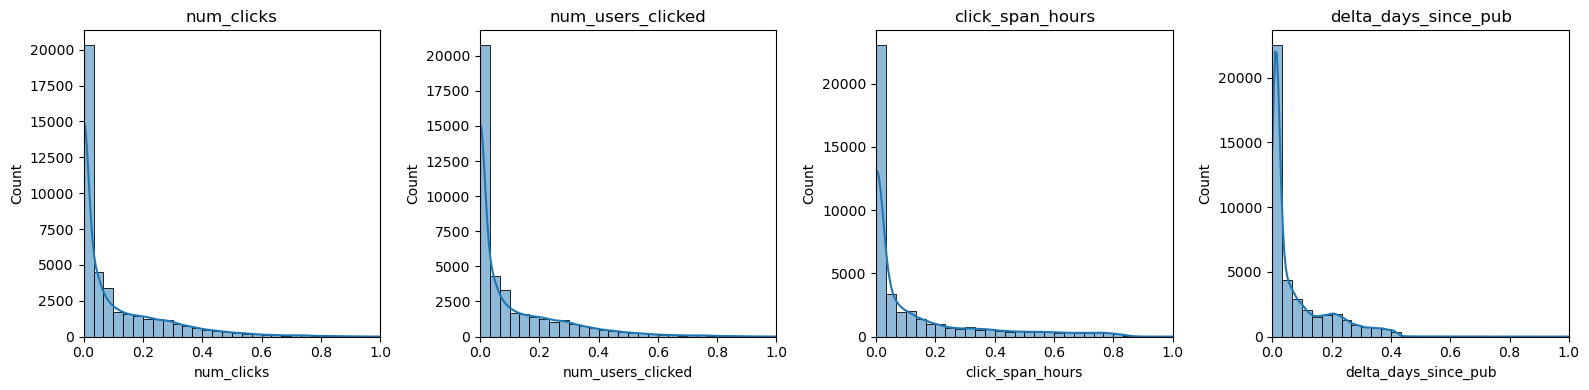

In [33]:
# Vérification de la variance
plot_feature_distributions(
    article_clicks_features,
    feature_columns=["num_clicks", "num_users_clicked", "click_span_hours", "delta_days_since_pub"]
)


### Assemblage du dataframe embeddings + features article

In [34]:
# Assure-toi que tous les DataFrames sont bien indexés par article_id
emb = embeddings_df_normalized.copy()
clicks = article_clicks_features.set_index('article_id')
words = words_count_normalized.set_index('article_id')

# Jointure sur les index (article_id)
articles_merged = emb.join([clicks, words], how='inner')

# Vérification de cohérence
assert articles_merged.shape[0] == len(item_mapping), "🚨 Mauvais nombre de lignes !"
assert articles_merged.index.equals(emb.index), "🚨 L’ordre des articles est compromis !"
print("✅ Fusion complète OK : embeddings + clics + nb_mots")

✅ Fusion complète OK : embeddings + clics + nb_mots


In [35]:
articles_merged

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,num_clicks,num_users_clicked,click_span_hours,delta_days_since_pub,words_count
article_id,,,,,,,,,,,,,,,,,,,,,
68866,0.337074,0.161814,-0.303480,0.320910,-0.021610,0.266760,0.200751,-0.280029,-0.203450,-0.168596,...,0.025730,0.050654,-0.035347,0.001251,-0.113606,0.673435,0.678764,0.103516,0.011187,0.657959
87205,0.666061,-0.206220,0.174248,0.026067,-0.000734,-0.309923,0.103950,-0.127303,0.029193,0.134414,...,-0.072838,-0.057685,0.041696,0.052638,-0.043400,0.662273,0.667355,0.417789,0.009207,0.597596
87224,0.799295,0.005616,0.207364,0.151673,-0.097152,-0.202503,-0.122100,-0.044804,0.333249,-0.045518,...,0.024366,0.079173,-0.054821,-0.006604,-0.100124,0.793485,0.798946,0.548621,0.009211,0.559740
96755,0.102214,-0.112103,-0.141209,0.016697,0.018852,0.316574,0.286397,-0.591907,0.104758,-0.023697,...,-0.050929,0.028645,0.212898,0.036964,-0.063012,0.813832,0.820379,0.410894,0.009705,0.649667
157541,0.309866,0.338222,-0.386221,0.283509,0.015701,0.284942,0.074527,-0.236329,-0.300462,0.011073,...,-0.032578,0.018913,-0.019048,-0.037524,-0.040259,0.530719,0.534286,0.767190,0.011234,0.683841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154578,0.440999,0.635580,-0.153953,-0.043207,0.137994,0.026182,-0.001366,-0.196612,-0.279122,0.039226,...,-0.054630,-0.076470,-0.043166,0.107388,0.068729,0.000000,0.000000,0.000000,0.153841,0.647357
180346,-0.125580,0.400876,-0.400133,-0.139200,0.024778,-0.373649,0.043064,-0.239197,-0.086140,-0.116611,...,-0.056998,-0.038615,-0.187310,0.101248,-0.043657,0.000000,0.000000,0.000000,0.094423,0.658492
272563,-0.073474,-0.237872,-0.304741,0.120750,-0.003001,-0.024495,0.134553,0.377020,0.209195,0.074884,...,0.033991,0.101698,0.090260,-0.080711,-0.010495,0.000000,0.000000,0.000000,0.015346,0.643205


In [36]:
# Vérification rapide :
print("Dimensions après fusion :", articles_merged.shape)
print("Nombre de NaN dans embeddings :")
print(articles_merged.iloc[:, -embeddings_df.shape[1]:].isna().sum().sum())  # colonne embeddings uniquement

Dimensions après fusion : (41367, 46)
Nombre de NaN dans embeddings :
0


### 🚧  Construction de la matrice sparse

In [37]:
# 4. Construire la matrice CSR finale
from scipy.sparse import csr_matrix
item_features_matrix = csr_matrix(articles_merged.values)

# 5. Vérification
print("✅ Matrice finale :", item_features_matrix.shape)

✅ Matrice finale : (41367, 46)


### Test d'entrainement - Apport des features clicks aux embeddings

In [36]:
model_fast_hybrid = train_lightfm_fast_sample(
    train_matrix=train_matrix,
    item_features=item_features_matrix,  # ajout de la matrice des embeddings+features items
    best_params=lightfm_hyperparams,
    sample_users=sample_users,
    valid_matrix=test_matrix,
    use_identity_features=False,  # 🔥 pour utiliser uniquement les embeddings
    max_epochs=50,
    patience=3
)

⚡ Fast LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0161


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0129


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0099


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0075
🛑 Early stopping (aucune amélioration depuis 3 évaluations)
✅ Meilleur score à l'epoch 5 : ndcg@5 = 0.0161


Les hyperparamètres ne sont pas idéaux pour cette matrice qui fournit de l'information complexe, mais on peut dire que les features clics ont amélioré la qualité de prédiction.

### Ajustement des paramètres du modèle

In [38]:
def grid_search_lightfm_sampled(train_matrix, test_matrix,
                                user_features=None, item_features=None,
                                sample_users=None,
                                param_grid=None,
                                k=5, num_threads=8, max_epochs=30,
                                eval_metric="ndcg",
                                eval_every=5, patience=3,
                                save_results_path="./results/lightfm_gridsearch_sample.csv"):
    import numpy as np
    import pandas as pd
    import os
    from itertools import product
    from lightfm import LightFM
    from joblib import Parallel, delayed
    from tqdm.notebook import tqdm

    def ndcg_at_k(model, test_interactions, train_interactions=None,
                  user_features=None, item_features=None,
                  k=5, num_threads=8):
        n_users, n_items = test_interactions.shape
        test_csr = test_interactions.tocsr()
        train_csr = train_interactions.tocsr() if train_interactions is not None else None

        def compute_ndcg(user_id):
            true_items = test_csr[user_id].indices
            if len(true_items) == 0:
                return None

            scores = np.array(model.predict(
                user_id,
                np.arange(n_items),
                user_features=user_features,
                item_features=item_features,
                num_threads=1
            ))

            if train_csr is not None:
                seen_items = train_csr[user_id].indices
                scores[seen_items] = -np.inf

            top_k_items = np.argpartition(-scores, k)[:k]
            top_k_items = top_k_items[np.argsort(-scores[top_k_items])]
            relevances = np.isin(top_k_items, true_items).astype(int)
            dcg = np.sum(relevances / np.log2(np.arange(2, k + 2)))
            idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k) + 2)))
            return dcg / idcg if idcg > 0 else 0.0

        results = Parallel(n_jobs=num_threads, backend="threading")(
            delayed(compute_ndcg)(user_id)
            for user_id in tqdm(range(n_users), total=n_users, desc="Calcul NDCG@k (parallèle)")
        )
        results = [r for r in results if r is not None]
        return np.mean(results) if results else 0.0

    if sample_users is not None:
        train_matrix = train_matrix[sample_users]
        test_matrix = test_matrix[sample_users]
        if user_features is not None:
            user_features = user_features[sample_users]

    all_combinations = list(product(
        param_grid['loss'],
        param_grid['no_components'],
        param_grid['learning_rate'],
        param_grid['user_alpha'],
        param_grid['item_alpha']
    ))

    print(f"🔍 Grid search sur {len(all_combinations)} combinaisons...")

    best_global_score = -np.inf
    best_model = None
    best_params = None
    results_rows = []

    for loss, no_components, learning_rate, user_alpha, item_alpha in all_combinations:
        print(f"\n🚀 Modèle : loss={loss}, comp={no_components}, lr={learning_rate}, "
              f"user_alpha={user_alpha}, item_alpha={item_alpha}")

        model = LightFM(
            loss=loss,
            no_components=no_components,
            learning_rate=learning_rate,
            user_alpha=user_alpha,
            item_alpha=item_alpha,
            random_state=42
        )

        best_local_score = -np.inf
        best_epoch = 0
        no_improve = 0

        try:
            ndcg_history = []

            for epoch in range(1, max_epochs + 1):
                model.fit_partial(train_matrix,
                                  user_features=user_features,
                                  item_features=item_features,
                                  epochs=1,
                                  num_threads=num_threads)

                if epoch % eval_every == 0:
                    score = ndcg_at_k(model, test_matrix,
                                      train_interactions=train_matrix,
                                      user_features=user_features,
                                      item_features=item_features,
                                      k=k,
                                      num_threads=num_threads)

                    print(f"📉 Epoch {epoch} — ndcg@{k} = {score:.4f}")
                    results_rows.append({
                        'loss': loss,
                        'no_components': no_components,
                        'learning_rate': learning_rate,
                        'user_alpha': user_alpha,
                        'item_alpha': item_alpha,
                        'epoch': epoch,
                        f'ndcg@{k}': score,
                        'status': 'ok'
                    })

                    ndcg_history.append(score)

                    if len(ndcg_history) >= 2 and all(s == 0.0 for s in ndcg_history[-2:]):
                        print("⚠️ NDCG@k bloqué à 0 — arrêt anticipé.")
                        break

                    if score > best_local_score:
                        best_local_score = score
                        best_epoch = epoch
                        no_improve = 0
                    else:
                        no_improve += 1
                        if no_improve >= patience:
                            print(f"🛑 Early stopping à l’epoch {epoch}")
                            break

            # ✅ Mise à jour du meilleur modèle global si meilleure combinaison trouvée
            if best_local_score > best_global_score:
                best_global_score = best_local_score
                best_model = model
                best_params = {
                    'loss': loss,
                    'no_components': no_components,
                    'learning_rate': learning_rate,
                    'user_alpha': user_alpha,
                    'item_alpha': item_alpha,
                    'best_epoch': best_epoch
                }

        except (ValueError, FloatingPointError) as e:
            print(f"❌ Échec du modèle : {e}")
            results_rows.append({
                'loss': loss,
                'no_components': no_components,
                'learning_rate': learning_rate,
                'user_alpha': user_alpha,
                'item_alpha': item_alpha,
                'epoch': 0,
                f'ndcg@{k}': 0.0,
                'status': f'error: {str(e)}'
            })
            continue

    print("\n✅ Grid search terminé !")
    if best_params is not None:
        print(f"🏆 Meilleurs paramètres : {best_params} — ndcg@{k} = {best_global_score:.4f}")
    else:
        print("⚠️ Aucun paramètre n'a permis d'obtenir une performance satisfaisante.")

    os.makedirs(os.path.dirname(save_results_path), exist_ok=True)
    pd.DataFrame(results_rows).to_csv(save_results_path, index=False)
    print(f"💾 Résultats sauvegardés dans {save_results_path}")

    return best_model, best_params, best_global_score


| Paramètre       | Valeurs                    | Justification                                         |
| --------------- | -------------------------- | ----------------------------------------------------- |
| `loss`          | `['bpr']`                  | Plus sensible aux surfits que `warp`  |
| `no_components` | `[16, 32, 64]`             | exploration de la **complexité du modèle**               |
| `learning_rate` | `[[0.05, 0.1, 0.2]`        | Pour adapter à la montée en complexité                |
| `user_alpha`    | `[1e-6, 1e-5]`             | Régularisation faible côté user = bon point de départ |
| `item_alpha`    | `[1e-5, 1e-4, 1e-3, 1e-2]` | 🔥 Focalisé sur **réguler les features item**         |


In [38]:
# Échantillon de 5000 utilisateurs
# sample_users = np.random.choice(train_matrix.shape[0], 5000, replace=False)

# Grille pour hybride simple
param_grid = {
    'loss': ['bpr'],
    'no_components': [16, 32, 64],
    'learning_rate': [0.05, 0.1, 0.2],
    'user_alpha': [1e-6, 1e-5],
    'item_alpha': [1e-5, 1e-4, 1e-3, 1e-2]
}

model, best_params, best_score = grid_search_lightfm_sampled(
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    item_features=item_features_matrix,  
    param_grid=param_grid,
    sample_users=sample_users,
    max_epochs=50,
    k=5,
    eval_metric="ndcg",
    save_results_path="./results/hybrid_gridsearch_sampled_item_features.csv"
)


🔍 Grid search sur 72 combinaisons...

🚀 Modèle : loss=bpr, comp=16, lr=0.05, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0237


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0226


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0205


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0196
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.05, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0222


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0195


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0117


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0062
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.05, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.05, user_alpha=1e-06, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.05, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0233


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0237


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0211


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0216


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0205
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=16, lr=0.05, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0221


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0196


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0108


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0050
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.05, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.05, user_alpha=1e-05, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.1, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0211


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0191


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0175


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0167
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.1, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0185


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0051


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0060


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0046
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.1, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.1, user_alpha=1e-06, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0216


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0190


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0179


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0170
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.1, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0195


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0060


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0065


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0048
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.1, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.1, user_alpha=1e-05, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=16, lr=0.2, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0180


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0150


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0128


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0114
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.2, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0058


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0047


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0034


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0016
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.2, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.2, user_alpha=1e-06, item_alpha=0.01
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=16, lr=0.2, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0176


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0158


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0126


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0086
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.2, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0068


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0047


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0026


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0017
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=16, lr=0.2, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=16, lr=0.2, user_alpha=1e-05, item_alpha=0.01
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0237


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0225


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0205


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0193
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0206


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0195


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0029


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0022
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-06, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0241


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0231


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0199


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0196
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0209


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0202


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0059


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0019
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-05, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0210


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0190


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0164


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0157
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0167


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0028


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0028


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0017
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0002


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-06, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0202


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0193


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0159


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0163
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0194


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0035


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0034


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0029
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0165


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0140


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0103


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0074
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0047


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0037


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0019


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0021
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-06, item_alpha=0.01
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0166


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0146


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0107


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0084
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0058


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0037


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0021


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0016
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-05, item_alpha=0.01
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0253


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0209


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0189


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0168
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0234


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0142


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0017


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0014
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-06, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0249


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0214


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0188


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0170
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0236


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0138


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0017


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0013
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-05, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0194


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0167


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0145


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0129
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0126


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0025


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0024


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0015
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0002


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0195


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0172


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0143


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0129
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0173


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0025


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0028


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0022
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=0.01


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0164


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0122


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0086


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0070
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0042


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0017


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0014


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0020
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=0.01
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0168


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0128


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0096


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0072
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0041


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0017


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0014


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0007
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-05, item_alpha=0.001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-05, item_alpha=0.01
❌ Échec du modèle : Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

✅ Grid search terminé !
🏆 Meilleurs paramètres : {'loss': 'bpr', 'no_components': 64, 'learning_rate': 0.05, 'user_alpha': 1e-06, 'item_alpha': 1e-05, 'best_epoch': 5} — ndcg@5 = 0.0253
💾 Résultats sauvegardés dans ./results/hybrid_gridsearch_sampled_item_features.csv


📌 Ce qu'on a appris:<br>
- 'bpr' donne de meilleurs résultats, il optimise le rang des items plutôt que la probabilité d'un clic
- lr = 0.05 est le plus performant (divergence si on l'augmente)
- item_alpha 1e-5 est optimal
- user_alpha ici moins critique, régularisation faible en tout cas
- l'augementation des dimensions à 64 aide légèrement

## Seconde approche hybride: Utilisation des embeddings item avec Dataset (introduction de features explicites)
🧩 LightFM peut utiliser n'importe quelle information sous forme de feature, y compris les id<br>
💡 Méthodologie: On prépare le Dataset puis on construit identity_features <br>
➡️ Ajoute les ID sous forme de features explicites.<br>
Enfin on compbine les ID avec les embeddings 

### 🔢 Étape 1 : Importer ce qu’il faut et préparer le Dataset

In [39]:
from lightfm.data import Dataset

# Convertir tous les IDs en str dès le départ
item_ids_str = [str(item_id) for item_id in item_mapping.keys()]

# Création du Dataset : ici les utilisateurs ne sont pas utilisés, donc liste vide
dataset = Dataset()

# On enregistre les items (IDs) dans le Dataset
dataset.fit(users=[], items=item_ids_str)

# → LightFM a maintenant un index pour chaque article: on a créé les id des items pour qu'ils soient connus de LightFM

### 🧩 Étape 2 : Ajout des IDs comme features explicites

In [40]:
# Déclarer les IDs comme features disponibles pour les items
dataset.fit_partial(items=item_ids_str, item_features=item_ids_str)

# Créer la structure sparse (N_items, N_item_features)
item_id_features = [(item_id, [item_id]) for item_id in item_ids_str]

identity_features = dataset.build_item_features(item_id_features, normalize=False)

# ✅ identity_features est une matrice (n_items, n_items)
# où chaque ligne a un 1 à l'emplacement correspondant à son ID

### 🔗 Étape 3 : concaténer les ID (sparse) et les item features (denses)

In [41]:
item_features

<41367x41 sparse matrix of type '<class 'numpy.float32'>'
	with 1696047 stored elements in Compressed Sparse Row format>

In [42]:
from scipy.sparse import hstack, csr_matrix

# Concaténation : chaque ligne contient les features d’ID + les valeurs des embeddings
combined_item_features = hstack([identity_features, item_features_matrix]).tocsr()


In [43]:
combined_item_features

<41367x41413 sparse matrix of type '<class 'numpy.float64'>'
	with 1882797 stored elements in Compressed Sparse Row format>

In [73]:
import os
from scipy.sparse import save_npz

# Crée le dossier './data/' s'il n'existe pas déjà
os.makedirs('./data/', exist_ok=True)

# Sauvegarde la matrice sparse combined_item_features
save_npz('./data/combined_item_features.npz', combined_item_features)

print("✅ Sauvegarde réussie dans './data/combined_item_features.npz'")


✅ Sauvegarde réussie dans './data/combined_item_features.npz'


✅ Vérification rapide :<br>
41367 lignes → correspond bien à ton nombre d’articles ✔️ <br>
41408 colonnes = 41367 (ID) + 41 (embeddings) ✔️<br>
Type : float32 en CSR → compatible avec LightFM ✔️<br>
Format sparse avec ≈ 1 + 41 = 42 features non nulles par ligne → cohérent ✔️

### 🧩 Étape 4 : Entrainement de LightFM avec combined_item_features

In [44]:
# Échantillon de 5000 utilisateurs
import numpy as np
# sample_users = np.random.choice(train_matrix.shape[0], 5000, replace=False)

# Entraînement
model_combined = train_lightfm_fast_sample(
    train_matrix=train_matrix,
    item_features=combined_item_features,
    best_params=lightfm_hyperparams,
    sample_users=sample_users,
    valid_matrix=test_matrix,
    use_identity_features=False,  # éviter de dupliquer les ID internes
    max_epochs=30,
    patience=3
)

⚡ Fast LightFM:   0%|          | 0/30 [00:00<?, ?it/s]

Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0367


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0390


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0370


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0314


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0254
🛑 Early stopping (aucune amélioration depuis 3 évaluations)
✅ Meilleur score à l'epoch 10 : ndcg@5 = 0.0390


Un gain brut de plus de 50% par rapport à la recherche grid_search sur item_features_matrix simple

In [45]:
    # Grille pour hybride avec matrice identité
param_grid = {
    'loss': ['bpr'],
    'no_components': [64],
    'learning_rate': [0.1, 0.2, 0.3],
    'user_alpha': [1e-6, 1e-5],
    'item_alpha': [1e-5, 5e-5, 1e-4]
}

# Grid_search rapide
model, best_params, best_score = grid_search_lightfm_sampled(
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    param_grid=param_grid,
    item_features=combined_item_features,
    sample_users=sample_users,
    k=5,
    max_epochs=50,
    eval_every=5,
    patience=3,
    save_results_path="./results/gridsearch_combined_features.csv"
)

🔍 Grid search sur 18 combinaisons...

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0400


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0403


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0406


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0376


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0372


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0328
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0320


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0166


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0083


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0095
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0182


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0064


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0041


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0015
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0410


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0403


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0428


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0399


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0399


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0356
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0329


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0238


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0080


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0100
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0246


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0061


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0050


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0023
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0332


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0395


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0374


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0332


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0284
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0270


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0171


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0120


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0094
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0105


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0042


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0027


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0017
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0347


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0403


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0426


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0370


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0330


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0251
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0244


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0162


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0108


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0075
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0115


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0042


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0009
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.3, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0197


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0276


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0275


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0246


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0208
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=64, lr=0.3, user_alpha=1e-06, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0133


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0105


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0042


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0039
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.3, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0060


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0022


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0004


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0000
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.3, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0221


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0295


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0311


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0301


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0261


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0255
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.3, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0168


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0111


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0048


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0037
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.3, user_alpha=1e-05, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0064


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0022


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0006


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0003
🛑 Early stopping à l’epoch 20

✅ Grid search terminé !
🏆 Meilleurs paramètres : {'loss': 'bpr', 'no_components': 64, 'learning_rate': 0.1, 'user_alpha': 1e-05, 'item_alpha': 1e-05, 'best_epoch': 20} — ndcg@5 = 0.0428
💾 Résultats sauvegardés dans ./results/gridsearch_combined_features.csv


## Approche hybride avec les features user

### Calcul de la matrice de features utilisateur - features engineering
On calcule feature par feature en adaptant la normalisation <br>
Avant tout calcul on filtre et on ordonne les utilisateurs de la même façon que dans la matrice user-item

In [12]:
def filter_and_order_user_features(df, user_mapping):
    """
    Filtre et trie les utilisateurs du DataFrame selon l’ordre attendu par la matrice user-item (via user_mapping),
    à utiliser AVANT toute transformation (normalisation, one-hot, etc.).

    Paramètres :
    - df : DataFrame contenant une colonne 'user_id'
    - user_mapping : dict {user_id → user_idx}

    Retourne :
    - df_filtered_ordered : DataFrame avec uniquement les utilisateurs de user_mapping, dans l’ordre
    - inv_user_mapping : dict {user_idx → user_id}
    """
    inv_user_mapping = {v: k for k, v in user_mapping.items()}
    ordered_user_ids = [inv_user_mapping[i] for i in range(len(inv_user_mapping))]

    # Filtrage strict
    missing_ids = [uid for uid in ordered_user_ids if uid not in df['user_id'].values]
    if missing_ids:
        print(f"⚠️ {len(missing_ids)} utilisateurs absents dans df.")
        ordered_user_ids = [uid for uid in ordered_user_ids if uid in df['user_id'].values]
    else:
        print("✅ Tous les utilisateurs requis sont présents pour la normalisation.")

    # Application de l’ordre
    df_filtered_ordered = df.set_index('user_id').loc[ordered_user_ids].reset_index()

    return df_filtered_ordered, inv_user_mapping


In [13]:
df_clicks_filtered_ordered, inv_user_mapping = filter_and_order_user_features(df_clicks, user_mapping)

✅ Tous les utilisateurs requis sont présents pour la normalisation.


In [14]:
df_clicks_filtered_ordered

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,0,1507340000920377,1507340000000,2,96755,1507340033155,4,3,20,1,...,0.586731,-1.060110,-0.603444,0.041161,-1.388792,-0.777144,0.437104,3.248686,0.564052,-0.961518
3,0,1507340000920377,1507340000000,2,313996,1507340063155,4,3,20,1,...,-0.413512,-1.389307,0.242264,0.503637,1.287935,-0.935367,0.545383,0.208773,0.226049,-0.911033
4,0,1507385847186982,1507385847000,2,160158,1507388090915,4,3,20,1,...,0.266321,-0.413638,-0.152308,-1.654221,0.346086,-0.906749,0.078396,-1.284569,-0.249823,-0.567254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784920,322881,1508210921149232,1508210921000,3,342473,1508211137084,4,3,20,1,...,2.835661,-1.177453,-1.887220,-0.975340,-0.775931,0.232800,-0.495012,1.263978,-0.841502,-0.050792
2784921,322881,1508210921149232,1508210921000,3,206415,1508211167084,4,3,20,1,...,-1.725272,-0.809947,0.204339,1.291324,0.254125,0.844132,-0.577113,-1.130715,1.476566,-2.068205
2784922,322887,1508211104344277,1508211104000,3,70986,1508211213614,4,3,2,1,...,1.192855,-1.897271,2.603547,-1.232298,-0.746784,1.632679,-1.428298,-1.542919,-0.802377,1.556529
2784923,322887,1508211104344277,1508211104000,3,211442,1508211245547,4,3,2,1,...,1.385261,-2.570798,-2.506212,0.495409,-1.370107,1.491792,0.522882,0.128736,-0.897418,-0.555844


#### 🚀 1 : Nombre de sessions par utilisateur

In [15]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_sessions(df_clicks):
    """
    Extrait et normalise le nombre de sessions par utilisateur (lissage log1p + MinMax).
    
    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_sessions_scaled']
    """
    sessions_per_user = df_clicks.groupby('user_id')['session_id'].nunique().reset_index()
    sessions_per_user.columns = ['user_id', 'num_sessions']
    
    # Log transform pour lisser
    sessions_per_user['num_sessions_log'] = np.log1p(sessions_per_user['num_sessions'])

    # MinMax scaling
    scaler = MinMaxScaler()
    sessions_per_user['num_sessions_scaled'] = scaler.fit_transform(
        sessions_per_user[['num_sessions_log']]
    )

    return sessions_per_user[['user_id', 'num_sessions_scaled']]


In [16]:
sessions_per_user = extract_number_of_sessions(df_clicks_filtered_ordered)
print(sessions_per_user.tail())

        user_id  num_sessions_scaled
221374   322864                  0.0
221375   322870                  0.0
221376   322879                  0.0
221377   322881                  0.0
221378   322887                  0.0


#### 🚀 2 : Nombre total de clics par utilisateur

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_clicks(df_clicks):
    """
    Extrait et normalise le nombre total de clics par utilisateur (log1p + MinMax).

    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_clicks_scaled']
    """
    clicks_per_user = df_clicks.groupby('user_id').size().reset_index(name='num_clicks')

    # Log transform
    clicks_per_user['num_clicks_log'] = np.log1p(clicks_per_user['num_clicks'])

    # MinMax scaling
    scaler = MinMaxScaler()
    clicks_per_user['num_clicks_scaled'] = scaler.fit_transform(
        clicks_per_user[['num_clicks_log']]
    )

    return clicks_per_user[['user_id', 'num_clicks_scaled']]


In [18]:
clicks_per_user = extract_number_of_clicks(df_clicks_filtered_ordered)
print(clicks_per_user.head())

   user_id  num_clicks_scaled
0        0           0.141501
1        1           0.205666
2        2           0.038937
3        3           0.262450
4        4           0.120949


#### 🚀 3 : Nombre d'articles distincts cliqués par utilisateur

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_distinct_articles(df_clicks):
    """
    Extrait et normalise le nombre d'articles distincts cliqués par utilisateur (log1p + MinMax).

    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_distinct_articles_scaled']
    """
    distinct_articles_per_user = df_clicks.groupby('user_id')['click_article_id'].nunique().reset_index()
    distinct_articles_per_user.columns = ['user_id', 'num_distinct_articles']

    # Log transform
    distinct_articles_per_user['num_distinct_articles_log'] = np.log1p(distinct_articles_per_user['num_distinct_articles'])

    # MinMax scaling
    scaler = MinMaxScaler()
    distinct_articles_per_user['num_distinct_articles_scaled'] = scaler.fit_transform(
        distinct_articles_per_user[['num_distinct_articles_log']]
    )

    return distinct_articles_per_user[['user_id', 'num_distinct_articles_scaled']]


In [20]:
distinct_articles_per_user = extract_number_of_distinct_articles(df_clicks_filtered_ordered)
print(distinct_articles_per_user.head())

   user_id  num_distinct_articles_scaled
0        0                      0.145607
1        1                      0.211634
2        2                      0.040067
3        3                      0.270066
4        4                      0.124459


#### 🚀 4 : Heure favorite de connexion par utilisateur - discrétisée

In [21]:
def extract_favorite_hour(df_clicks):
    """
    Extrait l'heure favorite de connexion basée sur session_start pour chaque utilisateur.
    """
    # Convertir session_start en heure
    df_clicks['session_start_hour'] = pd.to_datetime(df_clicks['session_start'], unit='ms').dt.hour

    # Trouver l'heure favorite (la plus fréquente) pour chaque utilisateur
    favorite_hour_per_user = (
        df_clicks.groupby('user_id')['session_start_hour']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_hour_per_user.columns = ['user_id', 'favorite_hour']

    return favorite_hour_per_user


In [22]:
favorite_hour_per_user = extract_favorite_hour(df_clicks_filtered_ordered)
print(favorite_hour_per_user.head())

   user_id  favorite_hour
0        0              1
1        1             15
2        2              2
3        3              2
4        4             21


In [23]:
def discretize_favorite_hour_6_periods(favorite_hour_df):
    """
    Discrétise l'heure favorite en 6 classes :
    Nuit profonde, Très tôt, Matin, Début après-midi, Fin après-midi, Soirée.
    """
    def map_hour_to_period(hour):
        if 0 <= hour <= 3:
            return 'Nuit_profonde'
        elif 4 <= hour <= 7:
            return 'Très_tôt'
        elif 8 <= hour <= 11:
            return 'Matin'
        elif 12 <= hour <= 15:
            return 'Début_après_midi'
        elif 16 <= hour <= 19:
            return 'Fin_après_midi'
        else:
            return 'Soirée'

    favorite_hour_df['favorite_period'] = favorite_hour_df['favorite_hour'].apply(map_hour_to_period)
    return favorite_hour_df[['user_id', 'favorite_period']]

In [24]:
favorite_period_per_user = discretize_favorite_hour_6_periods(favorite_hour_per_user)

#### 🚀 5 : Jour favori de connexion

In [25]:
def extract_favorite_day(df_clicks):
    """
    Extrait le jour favori de connexion (0=lundi, ..., 6=dimanche) pour chaque utilisateur.
    """
    # Convertir session_start en jour de la semaine
    df_clicks['session_start_dayofweek'] = pd.to_datetime(df_clicks['session_start'], unit='ms').dt.dayofweek

    # Trouver le jour favori
    favorite_day_per_user = (
        df_clicks.groupby('user_id')['session_start_dayofweek']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_day_per_user.columns = ['user_id', 'favorite_dayofweek']

    return favorite_day_per_user


In [26]:
favorite_day_per_user = extract_favorite_day(df_clicks_filtered_ordered)

#### 🚀 6 : Device préféré

In [27]:
def extract_favorite_device(df_clicks):
    """
    Extrait le device préféré (le plus utilisé) pour chaque utilisateur.
    """
    favorite_device_per_user = (
        df_clicks.groupby('user_id')['click_deviceGroup']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_device_per_user.columns = ['user_id', 'favorite_device']

    return favorite_device_per_user


#### 🚀 7 : Environnement préféré

In [28]:
def extract_favorite_environment(df_clicks):
    """
    Extrait l'environnement préféré (web/app) pour chaque utilisateur.
    """
    favorite_environment_per_user = (
        df_clicks.groupby('user_id')['click_environment']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_environment_per_user.columns = ['user_id', 'favorite_environment']

    return favorite_environment_per_user


#### 🚀 8 : Nombre de pays différents

In [29]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_countries(df_clicks):
    """
    Extrait et normalise le nombre de pays différents par utilisateur.
    """
    countries_per_user = (
        df_clicks.groupby('user_id')['click_country']
        .nunique()
        .reset_index()
    )
    countries_per_user.columns = ['user_id', 'num_countries']

    countries_per_user['num_countries_log'] = np.log1p(countries_per_user['num_countries'])
    scaler = MinMaxScaler()
    countries_per_user['num_countries_scaled'] = scaler.fit_transform(
        countries_per_user[['num_countries_log']]
    )

    return countries_per_user[['user_id', 'num_countries_scaled']]


In [30]:
favorite_device_per_user = extract_favorite_device(df_clicks_filtered_ordered)
favorite_environment_per_user = extract_favorite_environment(df_clicks_filtered_ordered)
countries_per_user = extract_number_of_countries(df_clicks_filtered_ordered)

print(favorite_device_per_user.head())
print(favorite_environment_per_user.head())
print(countries_per_user.head())


   user_id favorite_device
0        0               3
1        1               1
2        2               1
3        3               3
4        4               1
   user_id favorite_environment
0        0                    4
1        1                    4
2        2                    4
3        3                    4
4        4                    4
   user_id  num_countries_scaled
0        0                   0.0
1        1                   0.0
2        2                   0.0
3        3                   0.0
4        4                   0.0


#### Fusion des features

Fusionner toutes les features (num_sessions, num_clicks, num_distinct_articles, favorite_period, favorite_dayofweek, favorite_device, favorite_environment, num_countries).

One-Hot Encoder uniquement les catégorielles :

favorite_period

favorite_dayofweek

favorite_device

favorite_environment

Garder les numériques (num_sessions, num_clicks, num_distinct_articles, num_countries) tels quels - ils ont été normalisés de façon personnalisée.

In [31]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def build_user_features_df(
    sessions_per_user,
    clicks_per_user,
    distinct_articles_per_user,
    favorite_period_per_user,
    favorite_day_per_user,
    favorite_device_per_user,
    favorite_environment_per_user,
    countries_per_user
):
    """
    Construit le DataFrame des user features (non mappé), avec user_id comme index.
    """

    # 1. Fusionner tous les DataFrames
    df = sessions_per_user \
        .merge(clicks_per_user, on='user_id') \
        .merge(distinct_articles_per_user, on='user_id') \
        .merge(favorite_period_per_user, on='user_id') \
        .merge(favorite_day_per_user, on='user_id') \
        .merge(favorite_device_per_user, on='user_id') \
        .merge(favorite_environment_per_user, on='user_id') \
        .merge(countries_per_user, on='user_id')

    print(f"📄 Fusion terminée. Shape du DataFrame : {df.shape}")

    # 2. Encodage des colonnes catégorielles
    categorical_columns = ['favorite_period', 'favorite_dayofweek', 'favorite_device', 'favorite_environment']
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = encoder.fit_transform(df[categorical_columns])
    encoded_cat_cols = encoder.get_feature_names_out(categorical_columns)
    encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoded_cat_cols, index=df.index)

    print(f"✅ One-Hot Encoding terminé. Colonnes encodées : {list(encoded_cat_cols)}")

    # 3. Rassembler le tout
    df_numeric = df.drop(columns=categorical_columns)
    user_features_df = pd.concat([df_numeric, encoded_cats_df], axis=1)

    print(f"✅ DataFrame final prêt. Shape : {user_features_df.shape}")

    return user_features_df


In [32]:
user_features_df = build_user_features_df(
    sessions_per_user,
    clicks_per_user,
    distinct_articles_per_user,
    favorite_period_per_user,
    favorite_day_per_user,
    favorite_device_per_user,
    favorite_environment_per_user,
    countries_per_user
)

display(user_features_df.head())


📄 Fusion terminée. Shape du DataFrame : (221379, 9)
✅ One-Hot Encoding terminé. Colonnes encodées : ['favorite_period_Début_après_midi', 'favorite_period_Fin_après_midi', 'favorite_period_Matin', 'favorite_period_Nuit_profonde', 'favorite_period_Soirée', 'favorite_period_Très_tôt', 'favorite_dayofweek_0', 'favorite_dayofweek_1', 'favorite_dayofweek_2', 'favorite_dayofweek_3', 'favorite_dayofweek_4', 'favorite_dayofweek_5', 'favorite_dayofweek_6', 'favorite_device_1', 'favorite_device_3', 'favorite_device_4', 'favorite_device_5', 'favorite_environment_1', 'favorite_environment_2', 'favorite_environment_4']
✅ DataFrame final prêt. Shape : (221379, 25)


,user_id,num_sessions_scaled,num_clicks_scaled,num_distinct_articles_scaled,num_countries_scaled,favorite_period_Début_après_midi,favorite_period_Fin_après_midi,favorite_period_Matin,favorite_period_Nuit_profonde,favorite_period_Soirée,...,favorite_dayofweek_4,favorite_dayofweek_5,favorite_dayofweek_6,favorite_device_1,favorite_device_3,favorite_device_4,favorite_device_5,favorite_environment_1,favorite_environment_2,favorite_environment_4
0,0,0.197290,0.141501,0.145607,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0.269737,0.205666,0.211634,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.087302,0.038937,0.040067,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.269737,0.262450,0.270066,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4,0.149244,0.120949,0.124459,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Transformation en matrice sparse (CSR)

In [33]:
from scipy.sparse import csr_matrix

# Séparer et ordonner le DataFrame (si ce n’est pas déjà fait)
ordered_user_ids = [uid for uid, _ in sorted(user_mapping.items(), key=lambda x: x[1])]
user_features_df_ordered = user_features_df.set_index('user_id').loc[ordered_user_ids]

# Conversion en matrice CSR, sans user_id
user_features_matrix = csr_matrix(user_features_df_ordered.values)

In [34]:
print(user_features_matrix.shape)
print(f"Sparsité des user_features : {100 * (1 - user_features_matrix.nnz / user_features_matrix.size):.4f}%")

(221379, 24)
Sparsité des user_features : 0.0000%


### Entrainement et évaluation du modèle hybride avec user features

#### Test d'entrainement (avec sous-échantillon)

In [69]:
import numpy as np

# sample_users = np.random.choice(train_matrix.shape[0], 5000, replace=False)

model_fast = train_lightfm_fast_sample(
    train_matrix=train_matrix,
    item_features=None,
    user_features=user_features_matrix,
    best_params=lightfm_hyperparams,
    sample_users=sample_users,
    valid_matrix=test_matrix,
    max_epochs=60,
    patience=5
)

⚡ Fast LightFM:   0%|          | 0/60 [00:00<?, ?it/s]

Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0060


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0026


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0018


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0012


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0008


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0008
🛑 Early stopping (aucune amélioration depuis 5 évaluations)
✅ Meilleur score à l'epoch 5 : ndcg@5 = 0.0060


#### Optimisation par grid_search

In [70]:
param_grid = {
    'loss': ['warp', 'bpr'],
    'no_components': [32, 64],
    'learning_rate': [0.01, 0.1, 0.2],
    'user_alpha': [1e-6, 0],
    'item_alpha': [1e-5, 1e-4]
}


# Échantillon de 5000 utilisateurs
# sample_users = np.random.choice(train_matrix.shape[0], 5000, replace=False)

best_model, best_params, best_score = grid_search_lightfm_sampled(
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    user_features=user_features_matrix,
    sample_users=sample_users,
    param_grid=param_grid,
    k=5,
    num_threads=8,
    max_epochs=50,
    patience=5,
    save_results_path="./results/grid_user_features_sample.csv"
)


🔍 Grid search sur 48 combinaisons...

🚀 Modèle : loss=warp, comp=32, lr=0.01, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0340


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0377


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0382


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0396


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0389


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0405


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0434


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0442


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0478


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0488

🚀 Modèle : loss=warp, comp=32, lr=0.01, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0347


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0352


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0382


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0394


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0395


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0430


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0453


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0472


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0503

🚀 Modèle : loss=warp, comp=32, lr=0.01, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0317


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0375


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0384


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0405


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0406


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0404


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0413


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0457


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0473


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0499

🚀 Modèle : loss=warp, comp=32, lr=0.01, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0328


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0375


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0380


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0405


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0405


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0424


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0458


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0486


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0504

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0450


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0524


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0551


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0542


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0557


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0573


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0611


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0624


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0628


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0568

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0420


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0474


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0559


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0580


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0554


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0563


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0575


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0609


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0620


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0579

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0445


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0503


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0560


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0601


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0580


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0595


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0624


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0638


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0596


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0616

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0453


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0537


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0570


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0584


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0586


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0578


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0596


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0609


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0625


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0583

🚀 Modèle : loss=warp, comp=32, lr=0.2, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0092


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0214


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0230


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0232


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0231


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0227


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0216


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0218


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0205
🛑 Early stopping à l’epoch 45

🚀 Modèle : loss=warp, comp=32, lr=0.2, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0080


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0148


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0155


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0155


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0152


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0182


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0165


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0174


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0169


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0173

🚀 Modèle : loss=warp, comp=32, lr=0.2, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0108


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0164


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0176


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0155


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0163


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0139


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0160


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0151
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=warp, comp=32, lr=0.2, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0036


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0088


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0113


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0141


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0119


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0091


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0115


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0132


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0171


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0184

🚀 Modèle : loss=warp, comp=64, lr=0.01, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0340


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0379


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0409


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0437


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0484


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0509


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0522


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0543


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0544


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0586

🚀 Modèle : loss=warp, comp=64, lr=0.01, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0358


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0372


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0422


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0419


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0472


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0499


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0511


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0536


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0565


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0565

🚀 Modèle : loss=warp, comp=64, lr=0.01, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0337


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0379


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0409


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0444


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0466


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0512


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0501


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0529


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0546


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0568

🚀 Modèle : loss=warp, comp=64, lr=0.01, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0322


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0386


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0396


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0429


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0458


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0500


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0512


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0532


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0553


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0587

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0546


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0542


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0559


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0523


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0534


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0573


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0608


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0583


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0581


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0560

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0549


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0547


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0579


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0560


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0581


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0555


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0608


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0558


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0603


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0543

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0438


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0514


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0517


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0542


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0551


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0529


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0583


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0605


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0564


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0588

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0490


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0548


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0537


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0563


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0602


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0568


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0577


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0555


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0563


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0573
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=warp, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0109


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0231


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0246


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0242


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0238


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0232


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0221


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0214
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=warp, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0153


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0220


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0210


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0213


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0208


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0179


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0179
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=warp, comp=64, lr=0.2, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0120


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0180


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0197


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0184


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0176


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0168


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0166


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0167
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=warp, comp=64, lr=0.2, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0072


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0141


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0191


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0216


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0228


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0223


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0213


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0213


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0218


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0206
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=32, lr=0.01, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0439


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0431


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0386


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0313


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0262
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.01, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0437


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0423


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0382


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0349


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0302


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0252
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.01, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0439


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0438


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0389


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0360


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0312


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0260
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.01, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0435


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0424


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0383


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0351


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0304


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0254
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0102


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0018


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0008


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0006
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0092


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0014


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0016


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0003


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0004
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0095


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0017


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0009


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0007


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0007
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0097


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0017


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0009


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0003


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0004
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0062


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0017


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0011


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0008


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0005
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0064


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0011


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0002


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0005
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0062


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0017


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0011


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0011


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0009


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0005
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.2, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0060


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0012


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0012


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0004
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.01, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0387


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0301


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0227


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0177


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0124
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.01, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0390


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0349


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0291


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0231


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0162


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0120
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.01, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0388


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0362


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0302


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0232


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0177


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0125
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.01, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0388


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0349


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0286


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0229


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0159


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0118
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0099


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0015


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0014


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0011


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0012
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0109


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0018


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0012


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0008


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0009
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0102


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0016


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0011
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0112


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0023


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0008


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0012


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0009
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0066


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0012


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0011


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0008


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0012
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=1e-06, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0083


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0018


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0009


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0009
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=0, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0069


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0012


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0012


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0008


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0012
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.2, user_alpha=0, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0084


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0014


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0010


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0008


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0013


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0011
🛑 Early stopping à l’epoch 30

✅ Grid search terminé !
🏆 Meilleurs paramètres : {'loss': 'warp', 'no_components': 32, 'learning_rate': 0.1, 'user_alpha': 0, 'item_alpha': 1e-05, 'best_epoch': 40} — ndcg@5 = 0.0638
💾 Résultats sauvegardés dans ./results/grid_user_features_sample.csv


#### Utilisation d'une matrice identité user

In [35]:
# 🔢 Étape 1 : Préparation des identifiants utilisateur
from lightfm.data import Dataset
from scipy.sparse import hstack, csr_matrix

# Conversion des user_ids en str pour LightFM
user_ids_str = [str(uid) for uid in user_mapping.keys()]


In [36]:
# 🧩 Étape 2 : Initialisation du Dataset
# Création du Dataset : ici les items ne sont pas utilisés, donc liste vide
dataset = Dataset()

# Enregistrer les user_ids dans le Dataset
dataset.fit(users=user_ids_str, items=[])


In [37]:
# 🧩 Étape 3 : Déclarer les IDs comme features utilisateurs
# Enregistrement explicite des features utilisateur (ici leurs IDs)
dataset.fit_partial(users=user_ids_str, user_features=user_ids_str)

# Création de la structure identity_features
user_id_features = [(uid, [uid]) for uid in user_ids_str]
identity_user_features = dataset.build_user_features(user_id_features, normalize=False)


In [38]:
# 🔗 Étape 4 : Combiner les ID + features explicites

# Combinaison des deux types de features
combined_user_features = hstack([identity_user_features, user_features_matrix]).tocsr()


In [39]:
print(f"✔️ Dimensions attendues : {identity_user_features.shape[0]} lignes")
print(f"🧠 Nombre total de features : {combined_user_features.shape[1]} (IDs + one-hot)")

✔️ Dimensions attendues : 221379 lignes
🧠 Nombre total de features : 221403 (IDs + one-hot)


In [52]:
import os
from scipy.sparse import save_npz

# Crée le dossier './data/' s'il n'existe pas déjà
os.makedirs('./data/', exist_ok=True)

# Sauvegarde la matrice sparse combined_user_features (sera nécessaire à l'exécution du modèle)
save_npz('./data/combined_user_features.npz', combined_user_features)

print("✅ Sauvegarde réussie dans './data/combined_user_features.npz'")

✅ Sauvegarde réussie dans './data/combined_user_features.npz'


In [76]:
# Test d'entrainement
import numpy as np
# sample_users = np.random.choice(train_matrix.shape[0], 5000, replace=False)

# Entraînement
model_combined = train_lightfm_fast_sample(
    train_matrix=train_matrix,
    item_features=None,
    user_features=combined_user_features,
    best_params=lightfm_hyperparams,
    sample_users=sample_users,
    valid_matrix=test_matrix,
    use_identity_features=False,  # éviter de dupliquer les ID internes
    max_epochs=30,
    patience=3
)

⚡ Fast LightFM:   0%|          | 0/30 [00:00<?, ?it/s]

Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0317


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0345


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0367


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0362


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0374
✅ Meilleur score à l'epoch 30 : ndcg@5 = 0.0374


In [77]:
    # Grille pour hybride avec matrice identité
param_grid = {
    'loss': ['warp', 'bpr'],
    'no_components': [32, 64],
    'learning_rate': [0.01, 0.1],
    'user_alpha': [1e-5, 1e-4, 1e-3],  # ++ régularisation car ID = one-hot
    'item_alpha': [1e-5]  # inchangé, car item_features=None ici
}

# Grid_search rapide
model, best_params, best_score = grid_search_lightfm_sampled(
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    param_grid=param_grid,
    user_features=combined_user_features,
    item_features=None,
    sample_users=sample_users,
    k=5,
    max_epochs=50,
    eval_every=5,
    patience=3,
    save_results_path="./results/gridsearch_user_features_combined.csv"
)

🔍 Grid search sur 24 combinaisons...

🚀 Modèle : loss=warp, comp=32, lr=0.01, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0321


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0335


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0356


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0386


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0418


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0457


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0441


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0481


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0504


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0542

🚀 Modèle : loss=warp, comp=32, lr=0.01, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0341


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0346


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0340


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0376


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0441


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0437


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0456


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0483


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0524


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0527

🚀 Modèle : loss=warp, comp=32, lr=0.01, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0350


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0348


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0375


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0399


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0425


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0445


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0451


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0492


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0473


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0518

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.01, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0327


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0404


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0394


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0426


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0472


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0484


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0550


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0578


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0585


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0589

🚀 Modèle : loss=warp, comp=64, lr=0.01, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0336


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0413


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0432


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0410


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0462


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0504


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0552


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0588


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0599


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0606

🚀 Modèle : loss=warp, comp=64, lr=0.01, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0310


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0415


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0427


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0459


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0483


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0525


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0569


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0572


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0572

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=bpr, comp=32, lr=0.01, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0458


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0478


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0468


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0461


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0472
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=32, lr=0.01, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0465


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0476


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0478


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0487


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0507


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0491


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0481


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0467
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=bpr, comp=32, lr=0.01, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0476


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0513


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0503


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0537


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0574


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0589


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0593


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0593


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0614


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0616

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0519


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0397


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0395


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0423
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0549


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0490


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0519


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0537
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0363


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0458


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0588


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0582


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0611


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0601


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0648


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0676


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0699


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0678

🚀 Modèle : loss=bpr, comp=64, lr=0.01, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0464


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0471


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0460


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0464


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0425
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=64, lr=0.01, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0468


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0478


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0484


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0498


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0475


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0456


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0446
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=bpr, comp=64, lr=0.01, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0483


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0502


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0546


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0576


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0579


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0585


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0589


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0590


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0607


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0612

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0500


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0412


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0390


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0388
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0544


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0503


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0503


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0519
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0284


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0462


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0561


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0580


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0600


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0600


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0643


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0616


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0711


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0654

✅ Grid search terminé !
🏆 Meilleurs paramètres : {'loss': 'bpr', 'no_components': 64, 'learning_rate': 0.1, 'user_alpha': 0.001, 'item_alpha': 1e-05, 'best_epoch': 45} — ndcg@5 = 0.0711
💾 Résultats sauvegardés dans ./results/gridsearch_user_features_combined.csv


✅ Tests déjà effectués :
| Configuration                               | Objectif / intérêt principal               |
| ------------------------------------------- | ------------------------------------------ |
| 1. user-item seule                          | 🔹 Baseline                                |
| 2. + item features (embeddings)             | 🔹 Test content-based item uniquement      |
| 3. + item features *combined* (ID + emb)    | 🔹 Test effet des IDs + embeddings item    |
| 4. + user features (préférences uniquement) | 🔹 Exploiter le profil utilisateur         |
| 5. + user features *combined* (ID + prefs)  | 🔹 Ajout des IDs utilisateurs + cold-start |


## Approche hybride features user et features item (synergie user/item features)

In [78]:
param_grid = {
    'loss': ['bpr', 'warp'],  # comparer ranking explicite et implicite
    'no_components': [32, 64],  # compromis précision / temps
    'learning_rate': [0.05, 0.1],  # zone de confiance établie
    'user_alpha': [1e-5, 1e-4, 1e-3],  # plage testée efficace
    'item_alpha': [1e-5, 5e-5]  # centré sur les meilleurs résultats
}


# Échantillon de 5000 utilisateurs
# sample_users = np.random.choice(train_matrix.shape[0], 5000, replace=False)

best_model, best_params, best_score = grid_search_lightfm_sampled(
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    item_features=item_features_matrix,
    user_features=user_features_matrix,
    sample_users=sample_users,
    param_grid=param_grid,
    k=5,
    num_threads=8,
    max_epochs=50,
    patience=5,
    save_results_path="./results/grid_user+item_features_sample.csv"
)


🔍 Grid search sur 48 combinaisons...

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0153


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0120


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0110


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0136


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0166


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0118


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0151


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0116


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0118


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0103
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0171


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0112


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0095


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0127


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0148


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0094
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0177


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0127


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0110


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0156


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0173


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0143
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0145


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0097


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0087


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0113


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0148


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0089


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0138


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0087


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0084


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0098
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0117


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0107


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0077


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0114


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0117


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0078
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.05, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0150


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0124


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0103


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0141


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0124


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0089
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0112


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0129


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0120


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0122


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0181


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0061


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0152


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0087


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0093


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0062
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0091


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0075


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0065


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0134


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0136


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0106


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0131


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0064


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0041


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0043
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0114


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0094


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0098


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0132


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0166


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0087


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0144


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0100


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0095


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0086
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0102


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0087


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0068


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0101


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0225


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0080


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0036


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0067


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0045


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0047
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0085


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0086


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0076


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0125


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0131


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0067


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0118


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0082


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0069


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0070
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=32, lr=0.1, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0073


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0065


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0061


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0112


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0141


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0086


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0070


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0080


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0043


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0009
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0128


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0133


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0133


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0140


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0118


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0101


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0101


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0113


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0109
🛑 Early stopping à l’epoch 45

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0111


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0128


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0104


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0114


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0105


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0102


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0107
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0112


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0143


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0128


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0144


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0107


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0107


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0094


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0122


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0129
🛑 Early stopping à l’epoch 45

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0101


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0120


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0103


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0122


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0092


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0105


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0112


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0141


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0086


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0061

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0085


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0101


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0092


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0093


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0071


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0073


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0065
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0059


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0070


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0042


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0056


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0036


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0053


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0055
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0071


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0138


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0156


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0169


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0075


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0114


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0124


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0100


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0121
🛑 Early stopping à l’epoch 45

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0066


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0120


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0126


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0098


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0086


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0038


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0007


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0000
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0068


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0108


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0103


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0081


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0053


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0090


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0050
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0051


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0085


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0113


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0060


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0047


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0021


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0016


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0000
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0051


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0063


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0050


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0058


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0040


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0049


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0035
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0049


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0055


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0060


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0044


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0072


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0042


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0025


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0004


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0024


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0005
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=warp, comp=32, lr=0.05, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0374


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0360


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0369


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0358
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=warp, comp=32, lr=0.05, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0337


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0362


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0368


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0352


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0343


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0358
🛑 Early stopping à l’epoch 45

🚀 Modèle : loss=warp, comp=32, lr=0.05, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0331


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0339


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0341


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0348


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0356


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0349


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0352


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0356


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0359

🚀 Modèle : loss=warp, comp=32, lr=0.05, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0330


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0343


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0347


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0351


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0362


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0360


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0347
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=warp, comp=32, lr=0.05, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0342


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0331


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0361


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0363


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0350


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0353

🚀 Modèle : loss=warp, comp=32, lr=0.05, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0343


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0347


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0351


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0350


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0351


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0348


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0353

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0339


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0366


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0358


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0365


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0357
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0334


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0335


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0335


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0352


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0364


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0363


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0346


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0358

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0338


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0349


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0338


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0361


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0356


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0367


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0369


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0351


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0358

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0337


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0352


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0366


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0356


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0346


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0345


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0358
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0349


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0348


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0361


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0360


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0346


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0361


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0363


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0366


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0336


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0342

🚀 Modèle : loss=warp, comp=32, lr=0.1, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0328


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0358


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0341


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0340


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0356


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0336
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0360


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0360


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0352
🛑 Early stopping à l’epoch 35

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0339


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0346


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0349


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0351


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0362


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0362


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0373


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0361

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0350


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0346


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0358


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0367


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0362


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0379


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0350

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0348


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0351


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0361


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0346


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0343


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0351


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0358
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0350


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0338


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0350


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0352


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0358


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0355

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0361


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0357


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0352


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0350
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0327


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0345


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0337


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0338


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0342


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0342


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0361


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0344


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0353

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=1e-05, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0343


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0334


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0336


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0341


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0342


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0342
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0344


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0341


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0343


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0350


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0332


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0327


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0347


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0343


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0358


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0362

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0376


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0339


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0355


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0341


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0349


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0356
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0345


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0356


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0348


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0345


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0335


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0329


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0361


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0356


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0354


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0349

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0342


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0346


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0347


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0338


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0353


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0338


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0340


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0335


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0366


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0359

✅ Grid search terminé !
🏆 Meilleurs paramètres : {'loss': 'warp', 'no_components': 64, 'learning_rate': 0.05, 'user_alpha': 0.0001, 'item_alpha': 1e-05, 'best_epoch': 45} — ndcg@5 = 0.0379
💾 Résultats sauvegardés dans ./results/grid_user+item_features_sample.csv


## Approche hybride complète ID+informations des features item et user

In [79]:
    # Grille pour hybride avec matrice identité
param_grid = {
    'loss': ['bpr', 'warp'],                   # bpr performant, warp à retester avec +features
    'no_components': [64, 96],                 # 64 était top, 96 à tester avec +features
    'learning_rate': [0.05, 0.1],              # zone stable
    'user_alpha': [1e-4, 1e-3],                # pour encadrer les bons résultats avec matrix combinée
    'item_alpha': [1e-5, 5e-5, 1e-4]           # centré sur ta meilleure plage
}

# Grid_search rapide
model, best_params, best_score = grid_search_lightfm_sampled(
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    param_grid=param_grid,
    user_features=combined_user_features,
    item_features=combined_item_features,
    sample_users=sample_users,
    k=5,
    max_epochs=50,
    eval_every=5,
    patience=3,
    save_results_path="./results/gridsearch_user+item_features_combined.csv"
)

🔍 Grid search sur 48 combinaisons...

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0586


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0572


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0550


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0508
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0578


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0570


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0532


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0444
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0563


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0489


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0377


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0389
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0613


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0635


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0657


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0603


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0638


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0625
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0601


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0649


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0635


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0600


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0591
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=64, lr=0.05, user_alpha=0.001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0614


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0624


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0586


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0546


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0490
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0500


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0539


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0510


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0450


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0514
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0495


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0429


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0398


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0437
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0413


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0362


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0214


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0084
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0401


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0555


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0609


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0606


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0605


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0616


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0582


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0572


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0612
🛑 Early stopping à l’epoch 45

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0421


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0606


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0615


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0593


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0561


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0502
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=64, lr=0.1, user_alpha=0.001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0447


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0593


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0569


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0486


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0306
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=bpr, comp=96, lr=0.05, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0563


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0512


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0509


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0497
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=96, lr=0.05, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0577


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0514


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0480


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0396
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=96, lr=0.05, user_alpha=0.0001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0560


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0423


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0367


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0374
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=96, lr=0.05, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0540


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0596


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0630


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0613


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0628


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0604
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=96, lr=0.05, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0544


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0595


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0609


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0573


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0546


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0493
🛑 Early stopping à l’epoch 30

🚀 Modèle : loss=bpr, comp=96, lr=0.05, user_alpha=0.001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0564


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0545


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0560


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0425
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=96, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0471


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0505


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0502


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0513


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0517


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0496


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0487


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0491
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=bpr, comp=96, lr=0.1, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0470


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0428


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0386


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0326
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=96, lr=0.1, user_alpha=0.0001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0421


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0393


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0187


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0096
🛑 Early stopping à l’epoch 20

🚀 Modèle : loss=bpr, comp=96, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0280


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0479


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0531


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0576


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0608


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0584


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0611


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0570


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 45 — ndcg@5 = 0.0594


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.0581
🛑 Early stopping à l’epoch 50

🚀 Modèle : loss=bpr, comp=96, lr=0.1, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0322


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0500


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0553


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0579


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0596


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0548


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 35 — ndcg@5 = 0.0504


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0473
🛑 Early stopping à l’epoch 40

🚀 Modèle : loss=bpr, comp=96, lr=0.1, user_alpha=0.001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0359


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0553


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0542


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0452


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 25 — ndcg@5 = 0.0304
🛑 Early stopping à l’epoch 25

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.0001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.05, user_alpha=0.001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 15 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.0001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=64, lr=0.1, user_alpha=0.001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.05, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.05, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.05, user_alpha=0.0001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.05, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.05, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.05, user_alpha=0.001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.1, user_alpha=0.0001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.1, user_alpha=0.0001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.1, user_alpha=0.0001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.1, user_alpha=0.001, item_alpha=1e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.1, user_alpha=0.001, item_alpha=5e-05


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

🚀 Modèle : loss=warp, comp=96, lr=0.1, user_alpha=0.001, item_alpha=0.0001


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 5 — ndcg@5 = 0.0000


Calcul NDCG@k (parallèle):   0%|          | 0/5000 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0000
⚠️ NDCG@k bloqué à 0 — arrêt anticipé.

✅ Grid search terminé !
🏆 Meilleurs paramètres : {'loss': 'bpr', 'no_components': 64, 'learning_rate': 0.05, 'user_alpha': 0.001, 'item_alpha': 1e-05, 'best_epoch': 15} — ndcg@5 = 0.0657
💾 Résultats sauvegardés dans ./results/gridsearch_user+item_features_combined.csv


🎛 Bilan <br>


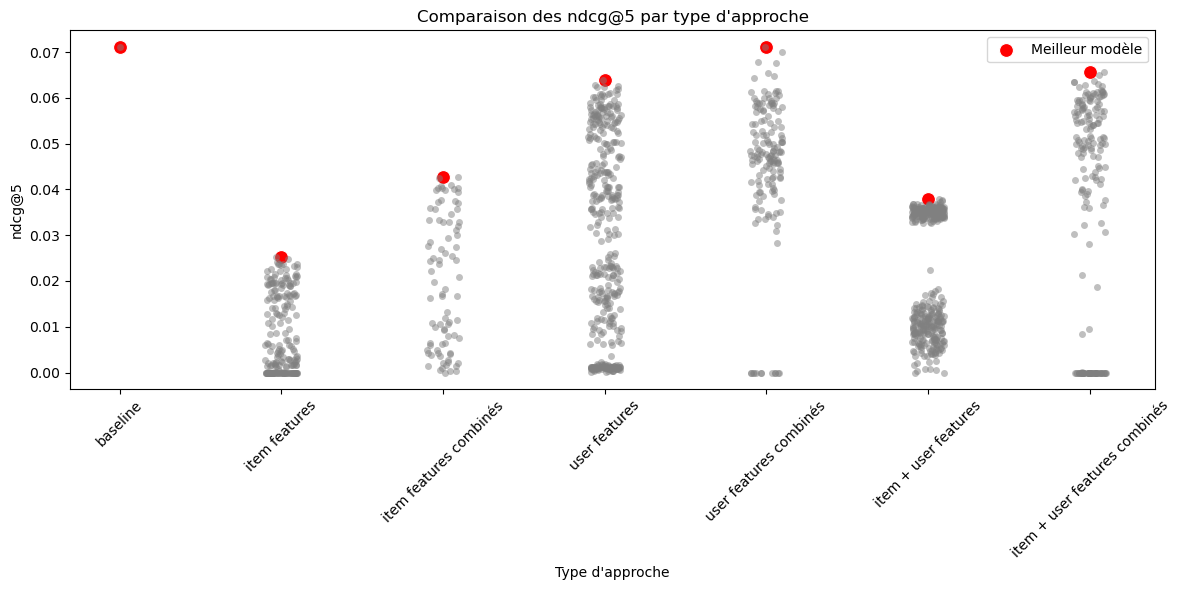

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mapping : nom de fichier → nom lisible pour l’axe des x
files_info = {
    "baseline": {"label": "baseline", "ndcg": 0.0712},
    "hybrid_gridsearch_sampled_item_features.csv": "item features",
    "gridsearch_combined_features.csv": "item features combinés",
    "grid_user_features_sample.csv": "user features",
    "gridsearch_user_features_combined.csv": "user features combinés",
    "grid_user+item_features_sample.csv": "item + user features",
    "gridsearch_user+item_features_combined.csv": "item + user features combinés"
}

# Dossier contenant les résultats
results_dir = "./results"

# Liste des DataFrames annotés
all_data = []

for filename, info in files_info.items():
    if filename == "baseline":
        all_data.append(pd.DataFrame({
            "ndcg@5": [info["ndcg"]],
            "essai": [info["label"]],
            "is_best": [True]
        }))
        continue
    path = os.path.join(results_dir, filename)
    df = pd.read_csv(path)
    df = df[df["status"] == "ok"].copy()
    df["essai"] = info
    best_ndcg = df["ndcg@5"].max()
    df["is_best"] = df["ndcg@5"] == best_ndcg
    all_data.append(df[["ndcg@5", "essai", "is_best"]])

# Concaténation
full_df = pd.concat(all_data, ignore_index=True)

# Création du graphique
plt.figure(figsize=(12, 6))
sns.stripplot(data=full_df, x="essai", y="ndcg@5", jitter=True, alpha=0.5, color="gray")
sns.scatterplot(
    data=full_df[full_df["is_best"]],
    x="essai", y="ndcg@5",
    color="red", s=100, label="Meilleur modèle"
)
plt.title("Comparaison des ndcg@5 par type d'approche")
plt.ylabel("ndcg@5")
plt.xlabel("Type d'approche")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Aucun des essais ne dépasse la baseline, les seules interactions sont à priori assez riches, il n'y a pas de gain clair en apportant des features.<br>
L'utilisation des informations user combinées est la plus intéressante mais pour avoir une meilleure stabilité on va choisir item+user features combinés pour faire un calcul complet avec évaluation pour comparer avec la baseline en full scale<br>
Il va aussi falloir adapter les hyperparamètres pour compenser l'hyper-sparsité des matrices. L'utilisation brute des hyperparamètres de user+item features amène un ndcg=0. En appliquant ce qui logiquement se passe en passant d'un sample vers full scale (augmenter la régularisation, diminuer le nombre de composants donc la complexité, diminuer le lr) ça ne donne pas de résultat.<br>
On exploitele fait que dans les essais séparés en combinant les item ou les user, on avait de bien meilleurs résultats avec les user, on peut réduire au maximum l'influence des items (item_alpha=1) qui dominent largement

## Calcul full scale avec matrice user features combinée

In [40]:
my_param_grid = {
    'loss': ['warp'],
    'no_components': [32, 64],
    'learning_rate': [0.005, 0.01, 0.05, 0.07, 0.1],
    'user_alpha': [1e-3, 1e-4, 1e-5],
    'item_alpha': [0.0]
}

best_model, best_params, best_global_score = grid_search_lightfm(
                                                train_matrix,
                                                test_matrix,
                                                user_features=combined_user_features,
                                                item_features=None,
                                                param_grid=my_param_grid,
                                                eval_metric="ndcg",
                                                min_metric_threshold=0.0001,
                                                save_results_path="./results/grid_warp_user_cobmined.csv",
                                                eval_every=10,
                                                max_epochs=30,
                                                patience=2
                                            )

🔍 Recherche sur 30 combinaisons...

🚀 Entraînement modèle : loss=warp, components=32, lr=0.005, user_alpha=0.001, item_alpha=0.0
📉 Epoch 10 — ndcg@5 = 0.0412
📉 Epoch 20 — ndcg@5 = 0.0468
📉 Epoch 30 — ndcg@5 = 0.0524

🚀 Entraînement modèle : loss=warp, components=32, lr=0.005, user_alpha=0.0001, item_alpha=0.0
📉 Epoch 10 — ndcg@5 = 0.0427
📉 Epoch 20 — ndcg@5 = 0.0519
📉 Epoch 30 — ndcg@5 = 0.0613

🚀 Entraînement modèle : loss=warp, components=32, lr=0.005, user_alpha=1e-05, item_alpha=0.0
📉 Epoch 10 — ndcg@5 = 0.0418
📉 Epoch 20 — ndcg@5 = 0.0527
📉 Epoch 30 — ndcg@5 = 0.0627

🚀 Entraînement modèle : loss=warp, components=32, lr=0.01, user_alpha=0.001, item_alpha=0.0
📉 Epoch 10 — ndcg@5 = 0.0643
📉 Epoch 20 — ndcg@5 = 0.0750
📉 Epoch 30 — ndcg@5 = 0.0774

🚀 Entraînement modèle : loss=warp, components=32, lr=0.01, user_alpha=0.0001, item_alpha=0.0
📉 Epoch 10 — ndcg@5 = 0.0685
📉 Epoch 20 — ndcg@5 = 0.0779
📉 Epoch 30 — ndcg@5 = 0.0808

🚀 Entraînement modèle : loss=warp, components=32, lr=0.01, 

In [145]:
import gc

# Supprimer tous les objets volumineux liés à l’ancien entraînement
try:
    del model
except NameError:
    pass # 

# Forcer le garbage collector à libérer la mémoire
gc.collect()

print("🧹 Mémoire RAM libérée.")


🧹 Mémoire RAM libérée.


In [14]:
best_params = {'loss': 'warp', 'no_components': 64, 'learning_rate': 0.05,
               'user_alpha': 0.0001, 'item_alpha': 0.0}

from scipy.sparse import load_npz

# Charge la matrice sparse sauvegardée
combined_user_features = load_npz('./data/combined_user_features.npz')

print("✅ Matrice chargée depuis './data/combined_user_features.npz'")

✅ Matrice chargée depuis './data/combined_user_features.npz'


In [15]:
final_model = train_lightfm_model(
    train_matrix=train_matrix,
    best_params=best_params,
    user_features=combined_user_features,
    # item_features=combined_item_features,
    valid_matrix=test_matrix,
    metric="ndcg",
    k=5,
    max_epochs=300,
    eval_every=10,
    patience=3
)

⏳ Entraînement LightFM:   0%|          | 0/300 [00:00<?, ?it/s]

Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 10 — ndcg@5 = 0.0820


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 20 — ndcg@5 = 0.0891


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 30 — ndcg@5 = 0.0947


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 40 — ndcg@5 = 0.0989


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 50 — ndcg@5 = 0.1020


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 60 — ndcg@5 = 0.1047


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 70 — ndcg@5 = 0.1066


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 80 — ndcg@5 = 0.1085


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 90 — ndcg@5 = 0.1098


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 100 — ndcg@5 = 0.1109


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 110 — ndcg@5 = 0.1120


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 120 — ndcg@5 = 0.1126


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 130 — ndcg@5 = 0.1139


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 140 — ndcg@5 = 0.1142


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 150 — ndcg@5 = 0.1151


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 160 — ndcg@5 = 0.1155


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 170 — ndcg@5 = 0.1163


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 180 — ndcg@5 = 0.1167


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 190 — ndcg@5 = 0.1168


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 200 — ndcg@5 = 0.1174


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 210 — ndcg@5 = 0.1175


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 220 — ndcg@5 = 0.1178


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 230 — ndcg@5 = 0.1183


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 240 — ndcg@5 = 0.1186


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 250 — ndcg@5 = 0.1190


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 260 — ndcg@5 = 0.1192


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 270 — ndcg@5 = 0.1197


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 280 — ndcg@5 = 0.1194


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 290 — ndcg@5 = 0.1196


Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

📉 Epoch 300 — ndcg@5 = 0.1198
✅ Meilleur score à l'epoch 300 : ndcg@5 = 0.1198


In [25]:
results = evaluate_lightfm_model_to_eval_results(
    model=final_model,
    train_matrix=train_matrix,
    test_matrix=test_matrix,
    best_params=best_params,
    experiment="User combined features",
    user_features=combined_user_features,
    item_features=None,
    k=5,
    num_threads=8
)

print(results)

Calcul NDCG@k (parallèle):   0%|          | 0/221379 [00:00<?, ?it/s]

Calcul RMSE/MAE normalisés:   0%|          | 0/221379 [00:00<?, ?it/s]

✅ Résultat ajouté à results/eval_results.csv
                                              modèle approche  n_users  \
0  User combined features, (warp, 64, lr=0.05, u_...  LightFM   221379   

   n_articles  n_interactions      RMSE       MAE     Hit@5     MAP@5  \
0       41367         2747674  0.237813  0.195049  0.035656  0.035656   

     NDCG@5  Precision@5  Recall@5  
0  0.119849     0.035656  0.178278  


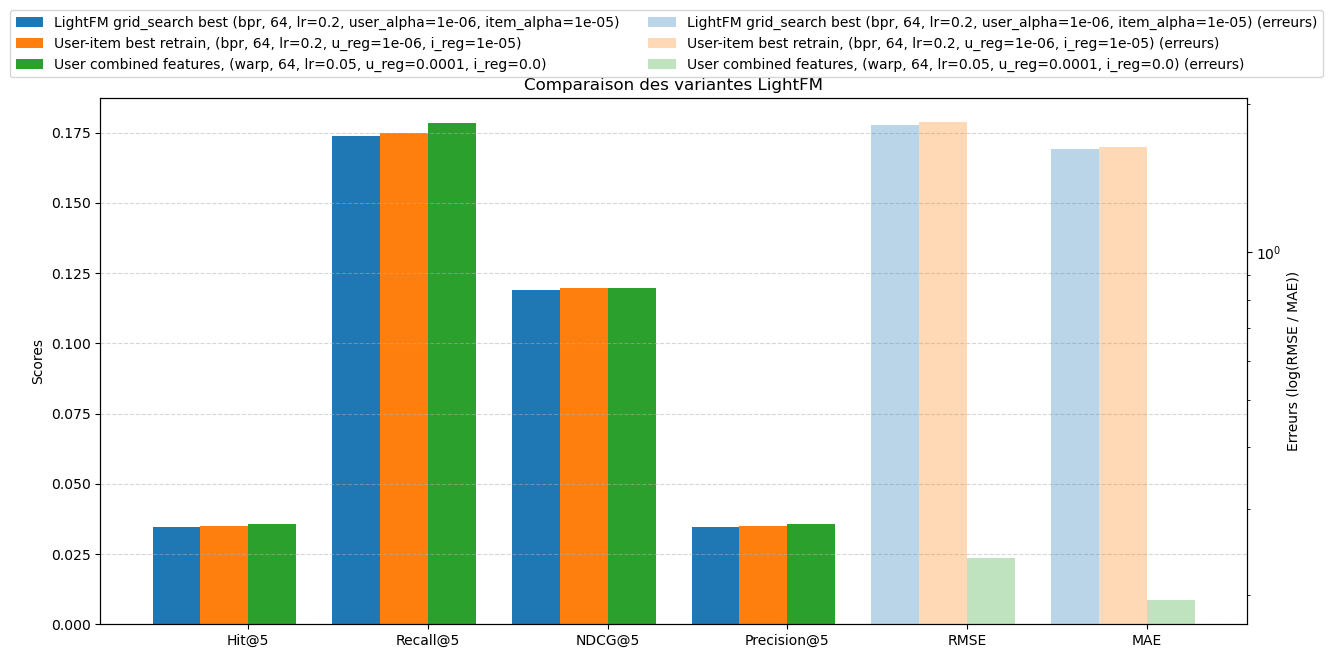

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Chargement des résultats
df = pd.read_csv("./results/eval_results.csv")

# Sélection des modèles LightFM
df_lightfm = df[df["approche"].str.contains("LightFM")]

# Métriques à afficher
main_metrics = ["Hit@5", "Recall@5", "NDCG@5", "Precision@5"]
secondary_metrics = ["RMSE", "MAE"]
labels = main_metrics + secondary_metrics
x = range(len(labels))
width = 0.8 / len(df_lightfm)  # Adapter la largeur à chaque barre

# Graphique
fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()

# Tracer une série par modèle LightFM
for i, (_, row) in enumerate(df_lightfm.iterrows()):
    vals = [row[m] for m in labels]
    offset = -0.4 + i * width
    label = row["modèle"]

    ax1.bar([j + offset for j in range(len(main_metrics))],
            [vals[j] for j in range(len(main_metrics))],
            width=width, label=label)
    ax2.bar([j + offset for j in range(len(main_metrics), len(labels))],
            [vals[j] for j in range(len(main_metrics), len(labels))],
            width=width, label=f"{label} (erreurs)", alpha=0.3)

# Mise en forme
ax1.set_xticks(list(x))
ax1.set_xticklabels(labels)
ax1.set_ylabel("Scores")
ax2.set_ylabel("Erreurs (log(RMSE / MAE))")
ax2.set_yscale("log")
ax1.set_title("Comparaison des variantes LightFM")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Légende et affichage
fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.show()


### Sauvegarde des mappings et tables pour la prod
| Mapping        | Clé       | Valeur    | Sens                   |
| -------------- | --------- | --------- | ---------------------- |
| `user_mapping` | `index`   | `user_id` | index → id (affichage) |
| `item_mapping` | `item_id` | `index`   | id → index (modèle)    |


In [43]:
import json
import os

# Conversion des clés en int natif
user_mapping = {int(k): v for k, v in user_mapping.items()}
# Créer le dossier ./data/ s'il n'existe pas
os.makedirs("./reco-mvp/model", exist_ok=True)

# Sauvegarde en JSON
with open("./reco-mvp/model/user_mapping.json", "w", encoding="utf-8") as f:
    json.dump(user_mapping, f, ensure_ascii=False, indent=4)

In [44]:
import json
import os

# Conversion explicite des clés en str pour compatibilité JSON (car ce sont des item_id)
item_mapping = {str(k): int(v) for k, v in item_mapping.items()}

# Sauvegarde en JSON
with open("./reco-mvp/model/item_mapping.json", "w", encoding="utf-8") as f:
    json.dump(item_mapping, f, ensure_ascii=False, indent=4)

In [42]:
import pandas as pd
import os
import json

# Agrégation des articles cliqués par utilisateur
user_clicks_df = df_clicks_filtered_ordered.groupby('user_id')['click_article_id'].apply(list).reset_index()

# Optionnel : renommer la colonne
user_clicks_df.columns = ['user_id', 'clicked_articles']

# Sauvegarde au format JSON
os.makedirs("./reco-mvp", exist_ok=True)
user_clicks_json = user_clicks_df.set_index('user_id')['clicked_articles'].to_dict()

# Option : convertir les clés en str si certains user_id ne sont pas sérialisables directement
user_clicks_json = {str(k): v for k, v in user_clicks_json.items()}

with open('./reco-mvp/user_clicked_articles.json', 'w', encoding='utf-8') as f:
    json.dump(user_clicks_json, f, ensure_ascii=False, indent=4)


In [41]:
import pandas as pd
from sklearn.decomposition import PCA
import os

# Réduction en 2D
article_ids = embeddings_df_filtered.index
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(embeddings_df_filtered.values)
embeddings_2d_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'], index=article_ids)
embeddings_2d_df.index.name = 'article_id'

# Réduction en 3D
pca_3d = PCA(n_components=3)
embeddings_3d = pca_3d.fit_transform(embeddings_df_filtered.values)
embeddings_3d_df = pd.DataFrame(embeddings_3d, columns=['x', 'y', 'z'], index=article_ids)
embeddings_3d_df.index.name = 'article_id'

# Création du dossier
os.makedirs("./reco-mvp", exist_ok=True)

# Sauvegarde en CSV
embeddings_2d_df.to_csv("./reco-mvp/article_embeddings_2d.csv", index=True)
embeddings_3d_df.to_csv("./reco-mvp/article_embeddings_3d.csv", index=True)
